In [39]:
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
from pytz import timezone, utc
from timezonefinder import TimezoneFinder
import geopy.distance
import matplotlib.pyplot as plt
import math

plt.rcParams['font.size'] = '20'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 999)


# AIR TRAVEL (March 2015-)

In [40]:
ROOT_DIR = '/Users/alexanderguo/Desktop/picrazy2.github.io/flightlog/'
df = pd.read_csv(ROOT_DIR + 'flightlog.csv')
airports = pd.read_csv(ROOT_DIR + 'airports.csv')

tf = TimezoneFinder()

def get_offset(t, lat, lng):
    """
    returns a location's time zone offset from UTC in hours.
    """
    tz_target = timezone(tf.certain_timezone_at(lng=lng, lat=lat))
    today_target = tz_target.localize(t)
    today_utc = utc.localize(t)
    return (today_utc - today_target).total_seconds() / 3600

def get_offset_tz(t, tz_target):
    """
    returns a location's time zone offset from UTC in hours.
    """
    today_target = tz_target.localize(t)
    today_utc = utc.localize(t)
    return (today_utc - today_target).total_seconds() / 3600


In [41]:
# Main Processing

df['Date'] = pd.to_datetime(df['Date'])

df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], left_on='Dep Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'Lat': 'Dep Lat', 'Long': 'Dep Long', 'City': 'Dep City', 'Country': 'Dep Country'})
df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], left_on='Arr Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'Lat': 'Arr Lat', 'Long': 'Arr Long', 'City': 'Arr City', 'Country': 'Arr Country'})

df['Distance'] = df.apply(lambda row: geopy.distance.distance((row['Dep Lat'], row['Dep Long']), (row['Arr Lat'], row['Arr Long'])).miles, axis=1)
df['Duration'] = df.apply(lambda row: np.sum(np.multiply(np.array([int(x) for x in row['Actual Duration'].split(':')]), np.array([60, 1]))) if isinstance(row['Actual Duration'], str) else 0, axis=1)

ALL_TIME_COLS = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Scheduled Duration', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)', 'Actual Duration']
DATETIME_COLS = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)']
important_cols = ['Date', 'Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Duration', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Distance', 'Dep Delay', 'Arr Delay', 'Class', 'Aircraft', 'Registration']


### Code to fix times below, it's not very clean ####
# format the time cols
for col in ALL_TIME_COLS:
    df[col] = pd.to_datetime(df[col]).dt.time
    if col in DATETIME_COLS:
        temp_col = df['Date'].astype(str)+' '+df[col].astype(str)
        temp_col = temp_col.replace('.*NaT', '', regex=True)
        df[col] = pd.to_datetime(temp_col)

# get timezones
df['Dep Timezone'] = df[['Dep Lat', 'Dep Long']].apply(lambda r: timezone(tf.certain_timezone_at(lng=r['Dep Long'], lat=r['Dep Lat'])), axis=1)
df['Arr Timezone'] = df[['Arr Lat', 'Arr Long']].apply(lambda r: timezone(tf.certain_timezone_at(lng=r['Arr Long'], lat=r['Arr Lat'])), axis=1)

# fill in UTC
for col in DATETIME_COLS:
    new_col = col.split('(')[0] + '(UTC)'
    deparr = 'Dep' if 'Dep' in col else 'Arr'
    for i, r in df.iterrows():
        if str(r[col]) != 'NaT':
            df.loc[i, new_col] = r[col]-timedelta(hours=get_offset(datetime.datetime.strptime(r[col].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), r[deparr + ' Lat'], r[deparr + ' Long']))
    
# get calculated flght times
for time_type in ['Scheduled', 'Actual']:
    df[time_type + ' difference'] = df[time_type + ' Arr Time (UTC)'] - df[time_type + ' Dep Time (UTC)']


# adjust dep/arr times, calculate delay
temp = pd.DataFrame()
for i, r in df.iterrows():
    for time_type in ['Scheduled', 'Actual']:
        if str(r[time_type + ' difference']) != 'NaT' and r[time_type + ' difference'].days < 0:
            r[time_type + ' Arr Time (UTC)'] = r[time_type + ' Arr Time (UTC)'] + timedelta(days=1)
    dep_delay = r['Actual Dep Time (UTC)'] - r['Scheduled Dep Time (UTC)']
    if dep_delay.days < 0 and dep_delay.seconds < 86400-3600: # can't have actual dep more than 1 hour before scheduled
        r['Actual Dep Time (UTC)'] = r['Actual Dep Time (UTC)'] + timedelta(days=1)
        r['Actual Arr Time (UTC)'] = r['Actual Arr Time (UTC)'] + timedelta(days=1)
    dep_delay = r['Actual Dep Time (UTC)'] - r['Scheduled Dep Time (UTC)']
    arr_delay = r['Actual Arr Time (UTC)'] - r['Scheduled Arr Time (UTC)']
    r['Dep Delay'] = np.nan if str(dep_delay) == 'NaT' else dep_delay.seconds//60 if dep_delay.days >= 0 else dep_delay.seconds//60-1440
    r['Arr Delay'] = np.nan if str(arr_delay) == 'NaT' else arr_delay.seconds//60 if arr_delay.days >= 0 else arr_delay.seconds//60-1440

    for time_type in ['Scheduled', 'Actual']:
        if str(r[time_type + ' Dep Time (Local)']) != 'NaT':
            r[time_type + ' Dep Time (Local)'] = r[time_type + ' Dep Time (UTC)'] + timedelta(hours=get_offset_tz(datetime.datetime.strptime(r[time_type + ' Dep Time (Local)'].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), r['Dep Timezone']))
        if str(r[time_type + ' Arr Time (Local)']) != 'NaT':    
            r[time_type + ' Arr Time (Local)'] = r[time_type + ' Arr Time (UTC)'] + timedelta(hours=get_offset_tz(datetime.datetime.strptime(r[time_type + ' Arr Time (Local)'].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), r['Arr Timezone']))
    
    if i > 0:
        r['Time since last flight'] = r['Actual Dep Time (UTC)'] - df.loc[i-1, 'Actual Arr Time (UTC)']
        r['Last flight arrival (UTC)'] = df.loc[i-1, 'Actual Arr Time (UTC)']
    temp = temp.append(r)
    
df = temp
df = df.drop(columns = ['Actual difference', 'Scheduled difference'])


TOTAL_DIST = df['Distance'].sum()
TOTAL_TIME = df['Duration'].sum()
NUM_FLIGHTS = df['Date'].count()
NUM_AIRLINES = df['Airline'].nunique()
NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))
sorted_by_flight_interval = df.sort_values('Time since last flight', ascending=False).reset_index()
LONGEST_INTERVAL = str(sorted_by_flight_interval.loc[0, 'Time since last flight'])
LONGEST_INTERVAL_0 = str(sorted_by_flight_interval.loc[0, 'Last flight arrival (UTC)'].date())
LONGEST_INTERVAL_1 = str(sorted_by_flight_interval.loc[0, 'Scheduled Dep Time (UTC)'].date())
sorted_by_flight_interval_reverse = df.sort_values('Time since last flight', ascending=True).reset_index()
SHORTEST_INTERVAL = str(sorted_by_flight_interval_reverse.loc[0, 'Time since last flight'])
SHORTEST_INTERVAL_0 = str(sorted_by_flight_interval_reverse.loc[0, 'Last flight arrival (UTC)'].date())
SHORTEST_INTERVAL_1 = str(sorted_by_flight_interval_reverse.loc[0, 'Scheduled Dep Time (UTC)'].date())


print('Total Distance Flown (miles): ' + str(TOTAL_DIST))
print('Total time in the air: ' + str(timedelta(minutes=int(TOTAL_TIME))))
print('Total Flights: ' + str(NUM_FLIGHTS))
print('Number of Airlines: ' + str(NUM_AIRLINES))
print('Number of Countries: ' + str(NUM_COUNTRIES))
print('Number of Airports: ' + str(NUM_AIRPORTS))
print('Longest time without flying: ' + LONGEST_INTERVAL + ', ' + LONGEST_INTERVAL_0 + ' to ' + LONGEST_INTERVAL_1)
# print('Shortest time without flying: ' + SHORTEST_INTERVAL + ', ' + SHORTEST_INTERVAL_0 + ' to ' + SHORTEST_INTERVAL_1)


df.to_csv('full_df.csv')

Total Distance Flown (miles): 533802.3741382291
Total time in the air: 45 days, 0:22:00
Total Flights: 233
Number of Airlines: 33
Number of Countries: 29
Number of Airports: 86
Longest time without flying: 157 days 18:22:00, 2016-07-10 to 2016-12-15


In [42]:
sorted_by_flight_interval_reverse.head(5)

,index,Actual Arr Time (Local),Actual Arr Time (UTC),Actual Dep Time (Local),Actual Dep Time (UTC),Actual Duration,Aircraft,Airline,Arr Airport,Arr City,Arr Connect,Arr Country,Arr Delay,Arr Lat,Arr Long,Arr Name,Arr Timezone,Class,Date,Dep Airport,Dep City,Dep Country,Dep Delay,Dep Lat,Dep Long,Dep Name,Dep Timezone,Distance,Domestic/International,Duration,Flight,Registration,Scheduled Arr Time (Local),Scheduled Arr Time (UTC),Scheduled Dep Time (Local),Scheduled Dep Time (UTC),Scheduled Duration,Seat,Timing Data,Last flight arrival (UTC),Time since last flight
0,16,2016-03-21 10:22:00,2016-03-21 02:22:00,2016-03-21 09:06:00,2016-03-21 01:06:00,01:16:00,A319,Sichuan,DNH,Dunhuang,NaN,China,-8.0,40.161098,94.809196,Dunhuang Airport,Asia/Shanghai,Economy,2016-03-21,LHW,Lanzhou,China,16.0,36.515202,103.620003,Lanzhou Zhongchuan Airport,Asia/Shanghai,540.319085,Domestic,76.0,3U8569,NaN,2016-03-21 10:30:00,2016-03-21 02:30:00,2016-03-21 08:50:00,2016-03-21 00:50:00,01:40:00,NaN,FlightStats,2016-03-21 00:06:00,0 days 01:00:00
1,121,2019-11-28 20:40:00,2019-11-28 20:40:00,2019-11-28 08:14:00,2019-11-28 13:14:00,07:27:00,B752,United,LHR,London,NaN,United Kingdom,-10.0,51.470600,-0.461941,London Heathrow Airport,Europe/London,Economy,2019-11-28,IAD,Washington,United States,-6.0,38.944500,-77.455803,Washington Dulles International Airport,America/New_York,3676.736546,International,447.0,UA122,N12116,2019-11-28 20:50:00,2019-11-28 20:50:00,2019-11-28 08:20:00,2019-11-28 13:20:00,NaT,NaN,Flightradar24,2019-11-28 12:12:00,0 days 01:02:00
2,87,2018-10-04 13:18:00,2018-10-04 05:18:00,2018-10-03 12:03:00,2018-10-03 16:03:00,13:15:00,B772,United,PEK,Beijing,NaN,China,-17.0,40.080101,116.584999,Beijing Capital International Airport,Asia/Shanghai,Economy,2018-10-03,EWR,Newark,United States,18.0,40.692501,-74.168701,Newark Liberty International Airport,America/New_York,6830.922824,International,795.0,UA89,N78005,2018-10-04 13:35:00,2018-10-04 05:35:00,2018-10-03 11:45:00,2018-10-03 15:45:00,NaT,22L,Flightradar24,2018-10-03 14:44:00,0 days 01:19:00
3,91,2018-11-23 14:00:00,2018-11-23 19:00:00,2018-11-23 10:19:00,2018-11-23 16:19:00,02:42:00,E75L,United,NAS,Nassau,NaN,Bahamas,-45.0,25.039000,-77.466202,Lynden Pindling International Airport,America/Nassau,Recliner First,2018-11-23,ORD,Chicago,United States,10.0,41.978600,-87.904800,Chicago O'Hare International Airport,America/Chicago,1311.392616,International,162.0,UA5481,N128SY,2018-11-23 14:45:00,2018-11-23 19:45:00,2018-11-23 10:09:00,2018-11-23 16:09:00,NaT,2A,Flightradar24,2018-11-23 14:57:00,0 days 01:22:00
4,141,2020-05-20 19:15:00,2020-05-20 23:15:00,2020-05-20 18:40:00,2020-05-20 22:40:00,00:35:00,E75L,United,BOS,Boston,NaN,United States,-33.0,42.364300,-71.005203,General Edward Lawrence Logan International Ai...,America/New_York,Recliner First,2020-05-20,EWR,Newark,United States,10.0,40.692501,-74.168701,Newark Liberty International Airport,America/New_York,200.540719,Domestic,35.0,UA3418,N747YX,2020-05-20 19:48:00,2020-05-20 23:48:00,2020-05-20 18:30:00,2020-05-20 22:30:00,NaT,NaN,Flightradar24,2020-05-20 21:16:00,0 days 01:24:00


# FLIGHTS SORTED BY DISTANCE

,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Distance,Dep Delay,Arr Delay,Class,Aircraft,Registration
64,2017-11-13,2017-11-13 06:00:00,2017-11-13 07:03:00,00:29:00,Delta,DL3854,PHL,JFK,93.709017,27.0,-7.0,Economy,CRJ9,N936XJ
57,2017-09-22,2017-09-22 08:30:00,2017-09-22 09:32:00,00:33:00,United,UA6071,IAD,PHL,134.682407,10.0,-19.0,Economy,CRJ7,N507MJ
193,2022-01-03,2022-01-03 18:10:00,2022-01-03 19:10:00,00:31:00,United,UA1778,IAH,AUS,140.223208,17.0,-12.0,Recliner First,B737,N16732
29,2016-12-23,2016-12-23 21:45:00,2016-12-23 22:50:00,00:43:00,Silkair,MI341,KUL,SIN,184.712792,7.0,-15.0,Economy,A319,9VSBE
65,2017-11-13,2017-11-13 09:00:00,2017-11-13 10:24:00,00:41:00,Delta,DL4010,JFK,BOS,186.718871,25.0,-18.0,Economy,CRJ9,N907XJ
107,2019-06-01,2019-06-01 16:10:00,2019-06-01 17:15:00,00:53:00,Sichuan,3U8818,LJG,KMG,199.275720,5.0,-8.0,Economy,A319,B6442
37,2017-03-20,2017-03-20 21:52:00,2017-03-20 23:05:00,00:37:00,United,UA1775,EWR,BOS,200.540719,27.0,-9.0,Recliner First,B739,N64809
42,2017-05-31,2017-05-31 08:55:00,2017-05-31 10:17:00,00:52:00,United,UA700,BOS,EWR,200.540719,11.0,-19.0,Economy,A320,N458UA
55,2017-08-12,2017-08-12 19:39:00,2017-08-12 21:00:00,00:45:00,United,UA276,EWR,BOS,200.540719,22.0,-14.0,Economy,A320,N481UA
58,2017-09-24,2017-09-24 17:05:00,2017-09-24 18:25:00,00:36:00,United,UA1922,EWR,BOS,200.540719,13.0,-31.0,Economy,B739,N63890


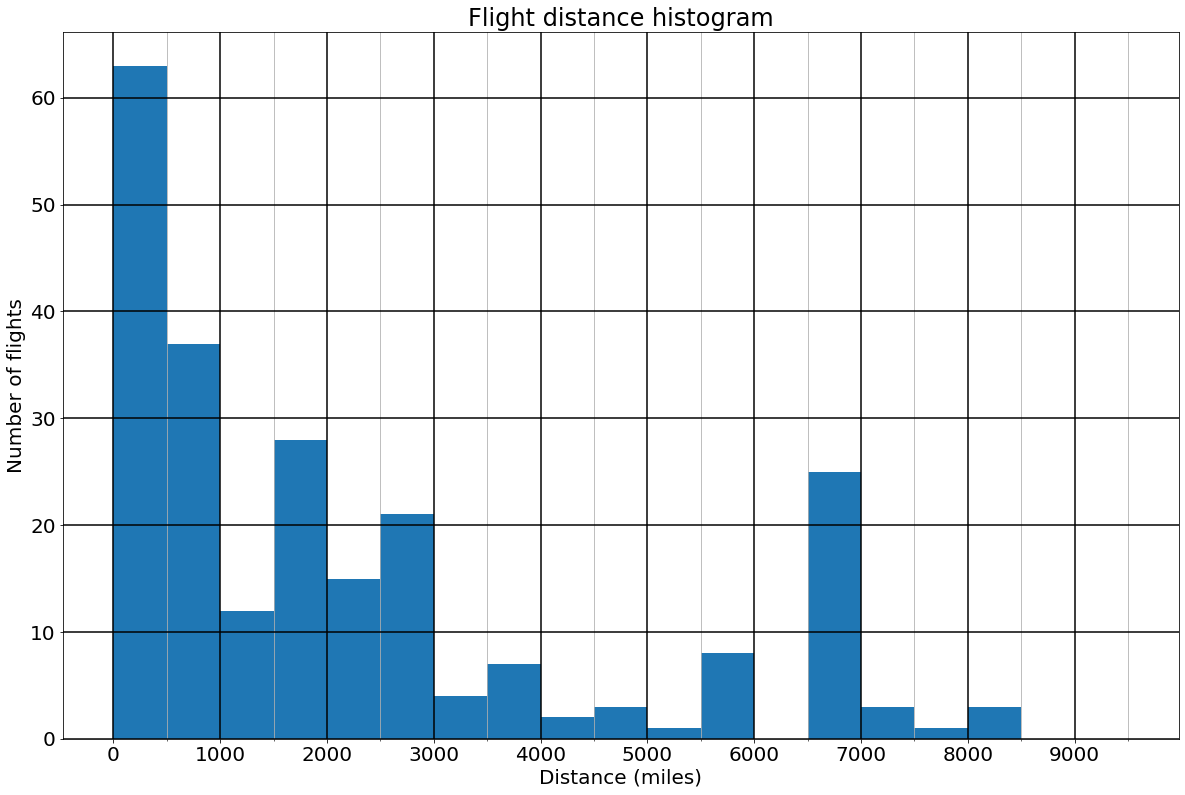

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(20,13))
bins = list(range(0, 10000, 500))
ax.hist(df['Distance'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if i%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Number of flights')
ax.set_title('Flight distance histogram')
plt.savefig('figures/distance_hist.jpg', bbox_inches='tight')

df.sort_values(['Distance'], ascending=True).head(10)[important_cols]


# FLIGHTS SORTED BY DURATION

,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Distance,Dep Delay,Arr Delay,Class,Aircraft,Registration
64,2017-11-13,2017-11-13 06:00:00,2017-11-13 07:03:00,00:29:00,Delta,DL3854,PHL,JFK,93.709017,27.0,-7.0,Economy,CRJ9,N936XJ
193,2022-01-03,2022-01-03 18:10:00,2022-01-03 19:10:00,00:31:00,United,UA1778,IAH,AUS,140.223208,17.0,-12.0,Recliner First,B737,N16732
57,2017-09-22,2017-09-22 08:30:00,2017-09-22 09:32:00,00:33:00,United,UA6071,IAD,PHL,134.682407,10.0,-19.0,Economy,CRJ7,N507MJ
141,2020-05-20,2020-05-20 18:30:00,2020-05-20 19:48:00,00:35:00,United,UA3418,EWR,BOS,200.540719,10.0,-33.0,Recliner First,E75L,N747YX
58,2017-09-24,2017-09-24 17:05:00,2017-09-24 18:25:00,00:36:00,United,UA1922,EWR,BOS,200.540719,13.0,-31.0,Economy,B739,N63890
37,2017-03-20,2017-03-20 21:52:00,2017-03-20 23:05:00,00:37:00,United,UA1775,EWR,BOS,200.540719,27.0,-9.0,Recliner First,B739,N64809
110,2019-07-08,2019-07-08 08:00:00,2019-07-08 09:18:00,00:39:00,United,UA2165,BOS,EWR,200.540719,18.0,-21.0,Economy,B737,N27724
65,2017-11-13,2017-11-13 09:00:00,2017-11-13 10:24:00,00:41:00,Delta,DL4010,JFK,BOS,186.718871,25.0,-18.0,Economy,CRJ9,N907XJ
26,2016-12-15,2016-12-15 09:15:00,2016-12-15 10:35:00,00:41:00,United,UA1710,BOS,EWR,200.540719,41.0,2.0,Recliner First,A320,N429UA
117,2019-09-28,2019-09-28 20:30:00,2019-09-28 21:47:00,00:41:00,United,UA421,EWR,BOS,200.540719,18.0,-18.0,Economy,B739,N66808


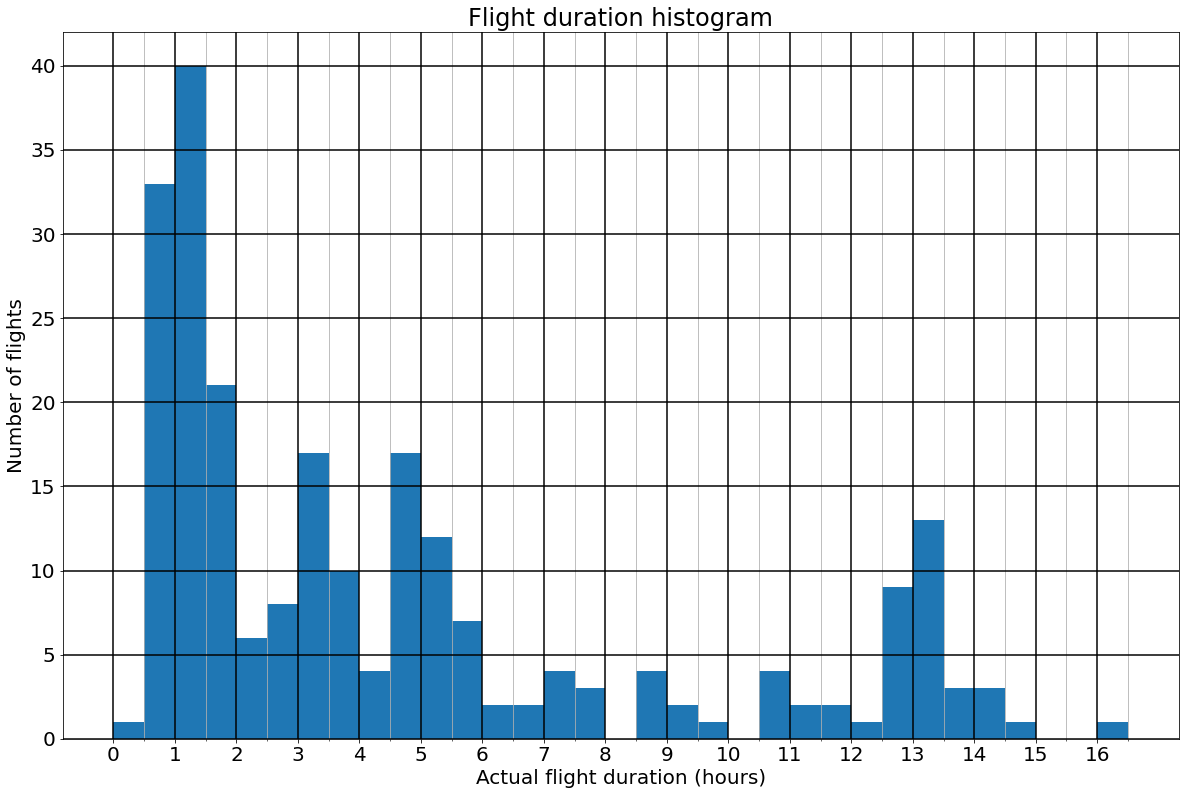

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20,13))
bins = list(range(0, math.ceil(df['Duration'].max()/30)*30+30, 30))
ax.hist(df['Duration'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if i%2 == 0])
ax.set_xticklabels([b//60 for i, b in enumerate(bins) if i%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Actual flight duration (hours)')
ax.set_ylabel('Number of flights')
ax.set_title('Flight duration histogram')
plt.savefig('figures/duration_hist.jpg', bbox_inches='tight')

df.sort_values(['Duration'], ascending=True).head(10)[important_cols]

# ALL COUNTRIES AND AIRPORTS

In [45]:
dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
dep_countries.columns = ['Country', 'Airport', 'Departures']
arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
arr_countries.columns = ['Country', 'Airport', 'Arrivals']
connect_countries = df[df['Arr Connect'] == 1].groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
connect_countries.columns = ['Country', 'Airport', 'Connections']
countries = pd.merge(pd.merge(dep_countries, arr_countries, how='outer'), connect_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first', 'Connections': 'first'})
countries['Total Visits'] = countries['Departures'] + countries['Arrivals'] - countries['Connections']
countries['Departures'] = countries['Departures'] - countries['Connections']
countries['Arrivals'] = countries['Arrivals'] - countries['Connections']
countries.astype('int32')

Departures  Arrivals  Connections  Total Visits
Country               Airport                                                 
Australia             BNE               1         1            0             2
                      SYD               1         1            0             2
Bahamas               NAS               1         1            0             2
Bermuda               BDA               1         1            0             2
Canada                YYZ               0         0            1             1
China                 CTU               1         1            0             2
                      DNH               1         1            0             2
                      HGH               1         1            0             2
                      HRB               1         1            0             2
                      KJI               1         1            0             2
                      KMG               0         0            1             1
                      KWL               1         1            0             2
                      LHW               0         0            1             1
                      LJG               1         1            0             2
                      PEK              23        25            0            48
                      PVG               2         2            0             4
                      SHA               1         0            0             1
                      SYX               1         1            0             2
                      SZX               1         0            0             1
                      URC               2         2            0             4
                      WUX               1         1            0             2
                      XIY               0         0            1             1
Costa Rica            SJO               1         1            0             2
Dominican Republic    PUJ               1         1            0             2
France                CDG               2         2            0             4
                      NCE               1         1            0             2
Germany               FRA               1         1            2             4
                      MUC               0         0            3             3
Iceland               KEF               1         1            0             2
Italy                 FCO               1         1            0             2
Japan                 HND               1         0            0             1
                      KIX               1         1            0             2
                      NRT               0         1            0             1
Malaysia              KUL               1         1            0             2
Mexico                MEX               1         1            0             2
                      PVR               1         1            0             2
New Zealand           AKL               2         2            0             4
                      CHC               0         1            0             1
                      ZQN               1         0            0             1
Portugal              LIS               1         1            3             5
Puerto Rico           SJU               1         1            0             2
Saint Kitts and Nevis SKB               1         1            0             2
Singapore             SIN               3         3            1             7
South Africa          CPT               2         1            0             3
                      PLZ               0         1            0             1
South Korea           GMP               1         1            0             2
                      ICN               1         1            0             2
Spain                 BCN               1         1            0             2
                      MAD               0         1            0             1
  

# AIRPORTS SORTED BY TOTAL VISITS

In [46]:
countries_sorted = countries.sort_values(by=['Total Visits'], ascending=False)
countries_sorted = countries_sorted.astype('int32')
countries_sorted.head(20)

Departures  Arrivals  Connections  Total Visits
Country       Airport                                                 
United States BOS              37        36            0            73
China         PEK              23        25            0            48
United States SFO              20        20            4            44
              EWR               7         6           22            35
Singapore     SIN               3         3            1             7
United States DEN               1         1            5             7
              LAX               3         3            1             7
              IAD               0         0            7             7
              PHL               3         4            0             7
              ORD               2         2            3             7
              JFK               1         2            2             5
Portugal      LIS               1         1            3             5
China         PVG               2         2            0             4
              URC               2         2            0             4
Germany       FRA               1         1            2             4
United States IAH               0         0            4             4
              DTW               2         2            0             4
New Zealand   AKL               2         2            0             4
Turkey        IST               2         2            0             4
France        CDG               2         2            0             4

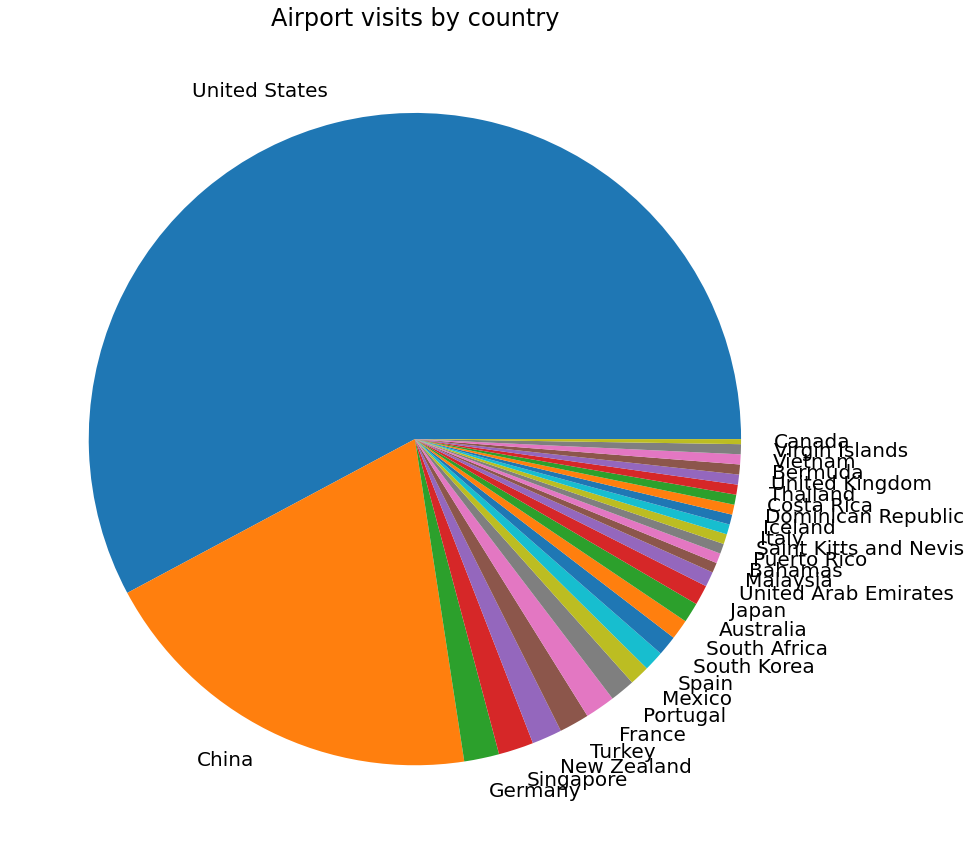

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
countries_sorted.reset_index().groupby('Country').agg({'Total Visits': sum}).sort_values(by='Total Visits', ascending=False).plot('Country', 'Total Visits', kind='pie', legend=False, ax=ax)
ax.set_title('Airport visits by country')
ax.set_ylabel('')
plt.savefig('figures/countries.jpg', bbox_inches='tight')

# TOP ROUTES

In [48]:
routes = df.groupby(['Dep Airport', 'Arr Airport']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes.columns = ['Count', 'Total Distance']
routes.head(10)

Count  Total Distance
Dep Airport Arr Airport                       
BOS         EWR             14     2807.570070
EWR         BOS             12     2406.488631
            PEK             10    68309.228239
SFO         BOS              6    16224.706890
PEK         EWR              5    34154.614120
BOS         ORD              3     2599.949013
PEK         IAD              3    20762.252704
IAD         BOS              3     1238.508572
BOS         IAD              3     1238.508572
DEN         BOS              2     3508.096100

In [49]:
df['Sorted Route'] = df.apply(lambda row: str(sorted([row['Dep Airport'], row['Arr Airport']])[0]) + ' ' + str(sorted([row['Dep Airport'], row['Arr Airport']])[1]), axis=1)
routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes_sorted.columns = ['Count', 'Total Distance']
routes_sorted[routes_sorted['Count'] >=2].reset_index()

,Sorted Route,Count,Total Distance
0,BOS EWR,26,5214.058701
1,EWR PEK,15,102463.842359
2,BOS SFO,8,21632.942519
3,BOS IAD,6,2477.017144
4,EWR SFO,4,10261.081002
5,BOS ORD,4,3466.598684
6,BOS DEN,4,7016.192200
7,IAD PEK,3,20762.252704
8,BOS PHL,3,840.060616
9,BOS LAX,3,7833.396174


# TOP AIRLINES

In [50]:
airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum, 'Duration': sum}).sort_values(by='Date', ascending=False)
airlines.columns = ['Count', 'Total Distance', 'Duration']
airlines

,Count,Total Distance,Duration
Airline,,,
United,133,342425.908652,40831.0
Lufthansa,10,30638.559266,3534.0
Hainan,9,37994.846495,4518.0
JetBlue,9,14963.728435,1844.0
China Southern,7,5826.802274,893.0
TAP,6,17163.365833,2058.0
Air China,5,6760.300960,1040.0
American,5,4662.374153,654.0
China Eastern,5,4002.392049,583.0


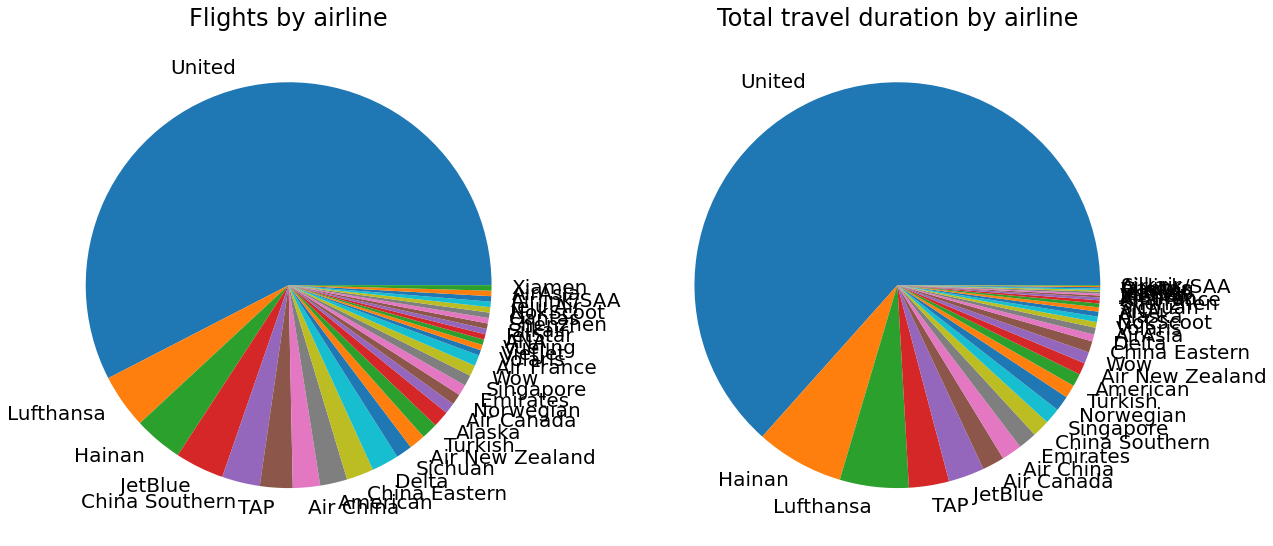

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
airlines.plot('Airline', 'Count', kind='pie', legend=False, ax=ax[0])
airlines.sort_values(by='Duration', ascending=False).plot('Airline', 'Duration', kind='pie', legend=False, ax=ax[1])
ax[0].set_title('Flights by airline')
ax[1].set_title('Total travel duration by airline')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig('figures/airlines.jpg', bbox_inches='tight')


# TOP AIRCRAFT

In [52]:
aircraft = df.groupby(['Aircraft']).agg({'Date': 'count', 'Distance': sum, 'Duration': sum}).sort_values(by='Date', ascending=False)
aircraft.columns = ['Count', 'Total Distance', 'Duration']
aircraft

,Count,Total Distance,Duration
Aircraft,,,
B738,32,39645.648892,5317.0
A320,28,21531.823085,3037.0
B772,26,148944.032069,17046.0
B739,17,12526.927492,1801.0
B789,15,74286.519851,8197.0
A321,14,19662.574447,2537.0
A319,11,8069.656310,1150.0
B752,11,27905.033455,3350.0
B737,8,4570.832260,736.0


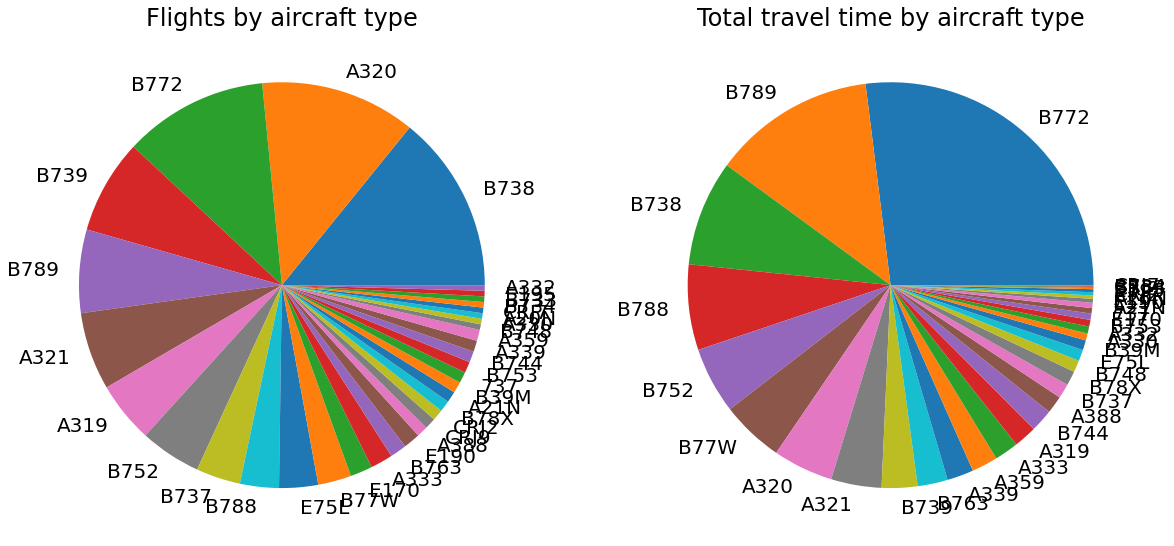

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
aircraft.plot('Aircraft', 'Count', kind='pie', legend=False, ax=ax[0])
aircraft.sort_values(by='Duration', ascending=False).plot('Aircraft', 'Duration', kind='pie', legend=False, ax=ax[1])
ax[0].set_title('Flights by aircraft type')
ax[1].set_title('Total travel time by aircraft type')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig('figures/aircrafts.jpg', bbox_inches='tight')


# TOP AIRCRAFT REGS

In [54]:
reg = df.groupby(['Registration', 'Aircraft']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False).head(15)
reg.columns = ['Count', 'Total Distance']
reg

,,Count,Total Distance
Registration,Aircraft,,
N76010,B772,3,20178.156746
N78005,B772,3,20492.768472
B7880,B789,2,1364.555397
B2750,B788,2,14044.305986
N69020,B772,2,9249.750914
N33284,B738,2,1954.588769
N68842,B739,2,2314.623049
N19136,B752,2,5408.235630
N33203,B738,2,1752.215445


# TRAVEL BY YEAR

In [55]:
dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Duration': sum, 'Date': 'count'})
dist_year.columns = ['Distance', 'Duration', 'Flights']
missing_years = set(range(dist_year.index.min(), dist_year.index.max())) - set(dist_year.index)
for yr in missing_years:
    dist_year = dist_year.append(pd.DataFrame({'Distance': 0, 'Duration': 0, 'Flights': 0}, index=[yr]))
dist_year

,Distance,Duration,Flights
Date,,,
2015,29436.434579,3573.0,10
2016,58570.729684,7014.0,22
2017,78048.415226,9502.0,39
2018,77923.939884,9277.0,26
2019,84244.238494,10091.0,32
2020,48040.013756,6065.0,30
2021,58951.069745,7405.0,33
2022,88373.720194,10319.0,35
2023,10213.812577,1576.0,6


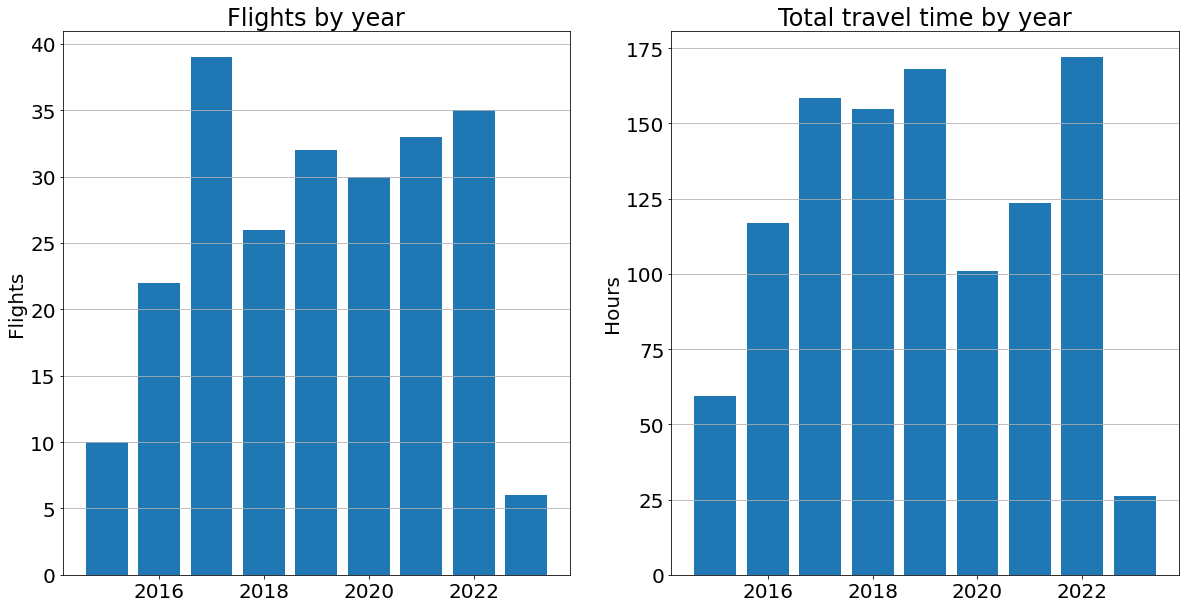

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].bar(dist_year.index, dist_year['Flights'])
ax[0].grid(axis='y')
ax[0].set_title('Flights by year')
ax[0].set_ylabel('Flights')
ax[1].bar(dist_year.index, dist_year['Duration']/60)
ax[1].grid(axis='y')
ax[1].set_title('Total travel time by year')
ax[1].set_ylabel('Hours')
plt.savefig('figures/by_year.jpg', bbox_inches='tight')


# TRAVEL BY MONTH

In [57]:
df['Month'] = df['Date']
dist_yearm = df.groupby([df['Date'].dt.year, df['Month'].dt.month]).agg({'Distance': sum, 'Duration': sum, 'Date': 'count'})
dist_yearm.columns = ['Distance', 'Duration', 'Flights']

dist_yearm.sort_values(by='Distance', ascending=False).head(30)

Distance  Duration  Flights
Date Month                                 
2019 12     20870.665731    2402.0        7
2021 6      18558.120149    2313.0       10
2022 11     18244.199207    2028.0        4
     2      17772.202544    2052.0        6
2016 3      17481.756684    2162.0        8
2018 3      17028.219491    1969.0        3
2022 12     16795.614951    1913.0        6
2019 8      15448.226232    1750.0        3
2022 10     15007.436791    1771.0        6
2020 1      14596.349780    1782.0        8
2021 11     14545.201558    1794.0        6
2017 10     14365.050635    1696.0        4
2016 12     14231.539360    1762.0        6
2018 10     14062.927086    1667.0        4
2015 3      14062.927086    1673.0        4
2017 3      14062.927086    1610.0        4
2016 7      12787.224365    1462.0        5
2018 12     11672.966019    1551.0        3
     1      11150.423053    1152.0        2
2015 12     10151.243377    1281.0        4
2017 1      10099.097863    1067.0        2
2021 5       9973.930007    1252.0        7
2017 12      9811.763983    1186.0        3
2019 11      9497.808366    1176.0        4
2018 5       9363.020046    1102.0        5
2019 1       9158.327715    1133.0        2
2020 11      9014.014088    1109.0        3
2018 6       8759.541167    1047.0        4
2019 5       8348.311894    1034.0        3
     6       8330.570778    1020.0        3

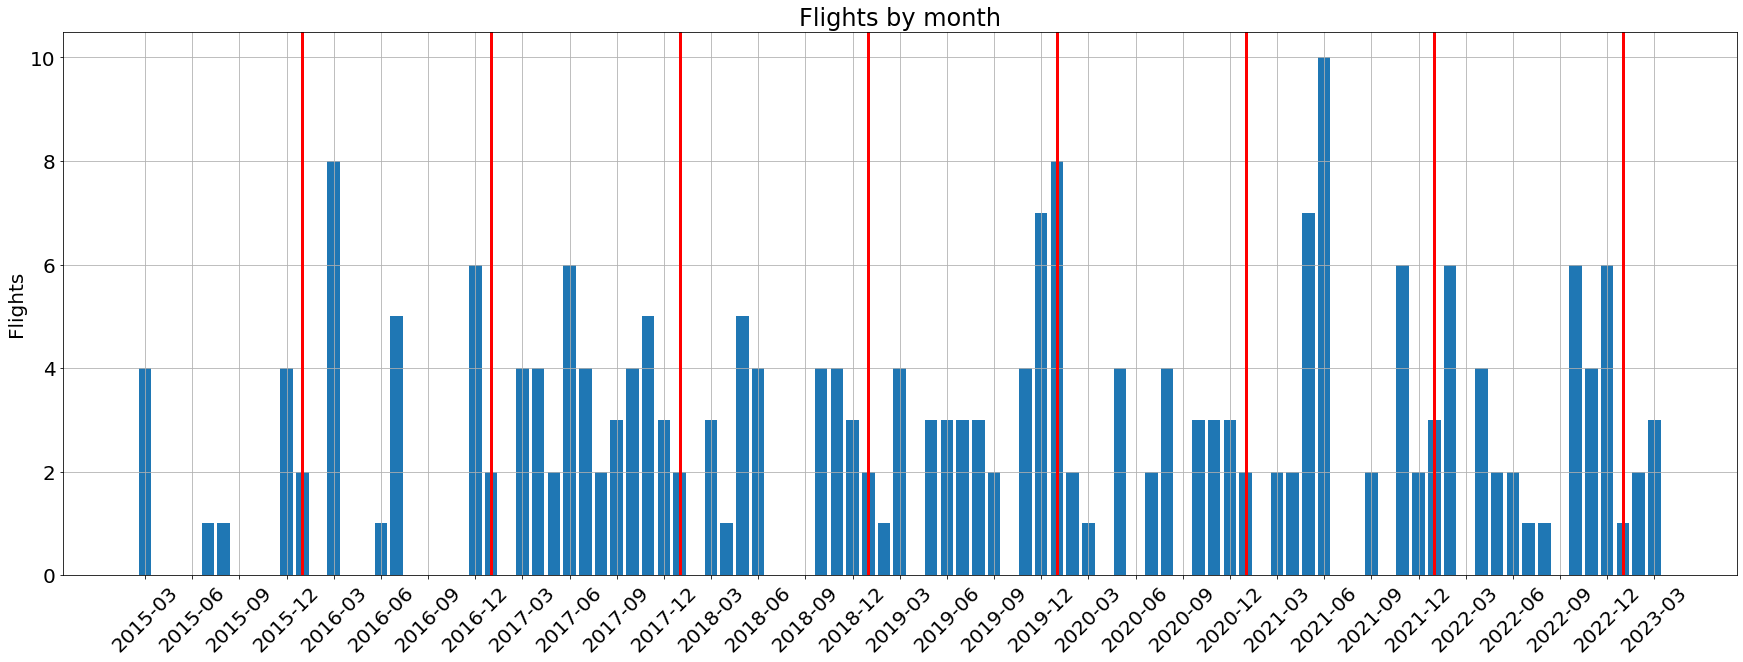

In [58]:
months = df['Month'].sort_values()
start_month = months.iloc[0]
end_month = months.iloc[-1]

index = pd.period_range(start_month, end_month, freq='M')
index_str = pd.DataFrame(index.astype(str), columns=['Y-M'])
# dist_yearm.reindex(index)

a = dist_yearm.reset_index()
a['Date'] = a['Date'].astype('int32').astype(str)
a['Month'] = a['Month'].astype('str').str.zfill(2)

a['Y-M'] = a['Date'] + '-' + a['Month']
a = a.merge(index_str, how='outer').sort_values(['Y-M']).fillna(0)

fig, ax = plt.subplots(figsize=(30,10))
ax.bar(a['Y-M'], a['Flights'], linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Flights')
ax.set_title('Flights by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig('figures/flights_by_month.jpg', bbox_inches='tight')


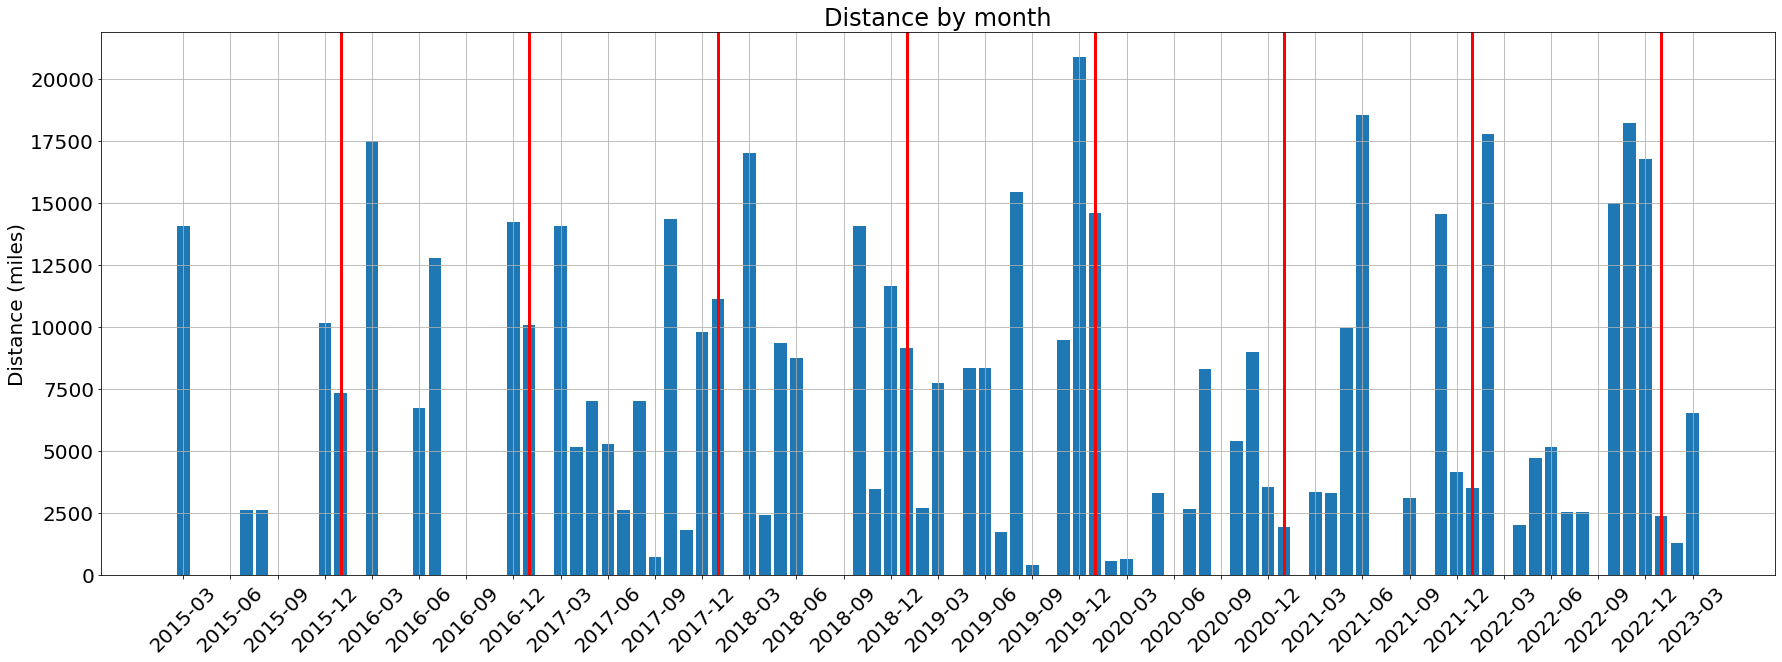

In [59]:
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(a['Y-M'], a['Distance'], linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Distance (miles)')
ax.set_title('Distance by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig('figures/distance_month.jpg', bbox_inches='tight')

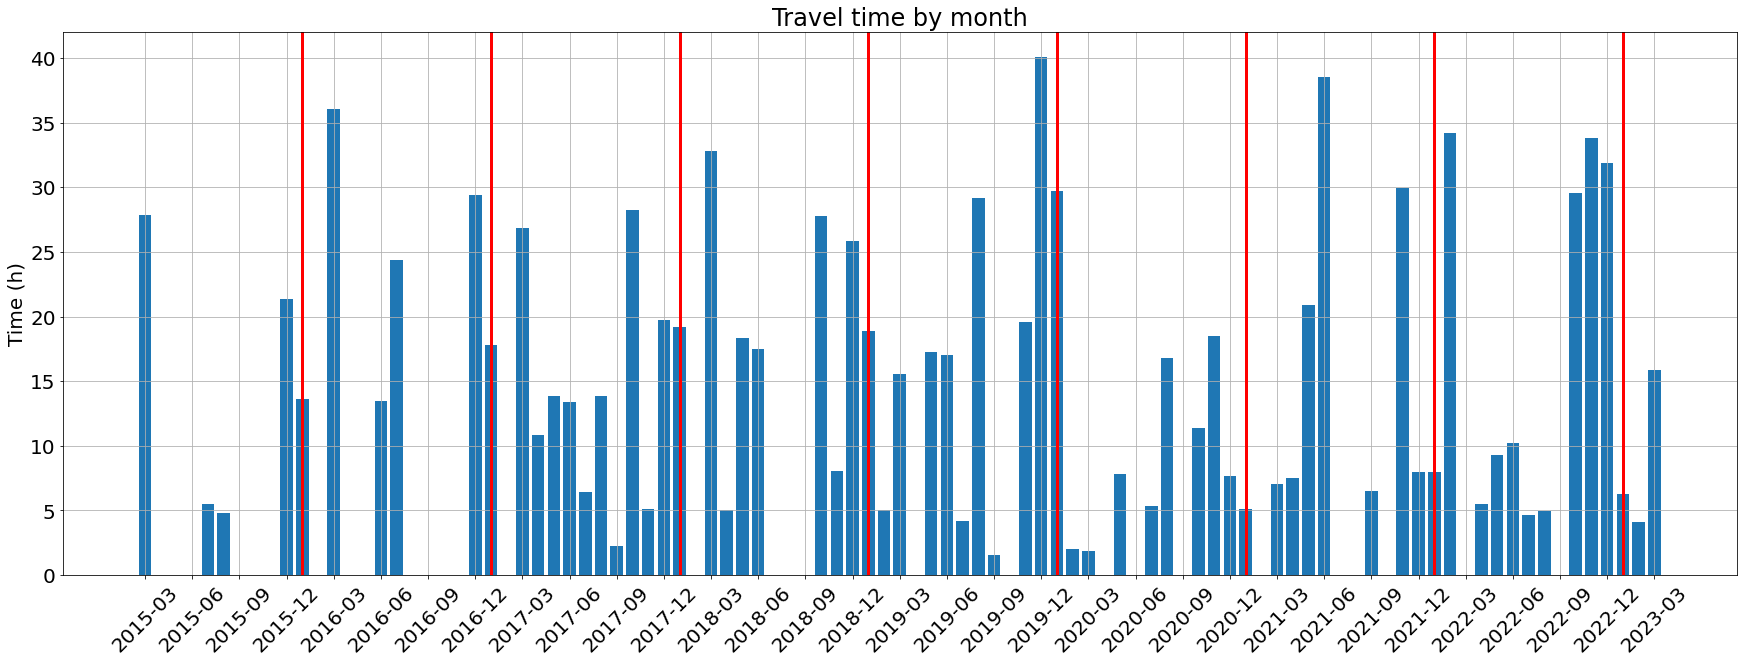

In [60]:
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(a['Y-M'], a['Duration']/60, linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Time (h)')
ax.set_title('Travel time by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig('figures/time_month.jpg', bbox_inches='tight')

# DOMESTIC AND INTERNATIONAL BREAKDOWN

In [61]:
dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count'})
dom_int.columns = ['Distance', 'Flights']
dom_int

,Distance,Flights
Domestic/International,,
Domestic,168142.983191,147
International,365659.390947,86


In [62]:
print('Domestic average dist: ' + str(dom_int.loc['Domestic', 'Distance'] / dom_int.loc['Domestic', 'Flights']))
print('International average dist: ' + str(dom_int.loc['International', 'Distance'] / dom_int.loc['International', 'Flights']))

Domestic average dist: 1143.8298176265005
International average dist: 4251.853383106203


In [63]:
year_dom_int = df.groupby([df['Date'].dt.year, 'Domestic/International']).agg({'Distance': sum, 'Date': 'count'})
year_dom_int.columns = ['Distance', 'Flights']
year_dom_int

Distance  Flights
Date Domestic/International                       
2015 Domestic                 8943.666107        7
     International           20492.768472        3
2016 Domestic                11296.768030       13
     International           47273.961655        9
2017 Domestic                18719.510846       28
     International           59328.904380       11
2018 Domestic                 7371.939874       11
     International           70552.000010       15
2019 Domestic                16722.896473       17
     International           67521.342021       15
2020 Domestic                35641.590777       24
     International           12398.422979        6
2021 Domestic                28859.795613       22
     International           30091.274133       11
2022 Domestic                34327.215785       21
     International           54046.504408       14
2023 Domestic                 6259.599685        4
     International            3954.212891        2

In [64]:
clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count'})
clas.columns = ['Distance', 'Flights']
clas

,Distance,Flights
Class,,
Economy,347288.180880,169
International First,5699.234908,1
Lie-flat Business,147735.681000,30
Premium Economy,9947.886411,4
Recliner First,23131.390940,29


# FARE CLASS BREAKDOWN

In [65]:
year_clas = df.groupby([df['Date'].dt.year, 'Class']).agg({'Distance': sum, 'Date': 'count'})
year_clas.columns = ['Distance', 'Flights']
year_clas

Distance  Flights
Date Class                                     
2015 Economy              29035.353141        8
     Recliner First         401.081439        2
2016 Economy              31517.190836       16
     Lie-flat Business    26852.998129        5
     Recliner First         200.540719        1
2017 Economy              51106.089836       32
     Lie-flat Business    23930.111893        4
     Recliner First        3012.213497        3
2018 Economy              59661.336598       19
     Lie-flat Business    14788.612150        3
     Recliner First        3473.991137        4
2019 Economy              45538.773721       23
     Lie-flat Business    38092.087863        7
     Recliner First         613.376910        2
2020 Economy              27504.377401       19
     Lie-flat Business    15315.037254        4
     Recliner First        5220.599101        7
2021 Economy              34460.430966       24
     Lie-flat Business    19675.252363        5
     Premium Economy       2418.828090        1
     Recliner First        2396.558327        3
2022 Economy              58250.815806       22
     International First   5699.234908        1
     Lie-flat Business     9081.581348        2
     Premium Economy       7529.058321        3
     Recliner First        7813.029810        7
2023 Economy              10213.812577        6


# CLASS AND TRIP TYPE BREAKDOWN

In [66]:
clas_dom_int = df.groupby(['Domestic/International', 'Class']).agg({'Distance': sum, 'Date': 'count'})
clas_dom_int.columns = ['Distance', 'Flights']
clas_dom_int

Distance  Flights
Domestic/International Class                                      
Domestic               Economy              118728.325172      112
                       Lie-flat Business     25463.072019        8
                       Premium Economy        9947.886411        4
                       Recliner First        14003.699590       23
International          Economy              228559.855708       57
                       International First    5699.234908        1
                       Lie-flat Business    122272.608982       22
                       Recliner First         9127.691349        6

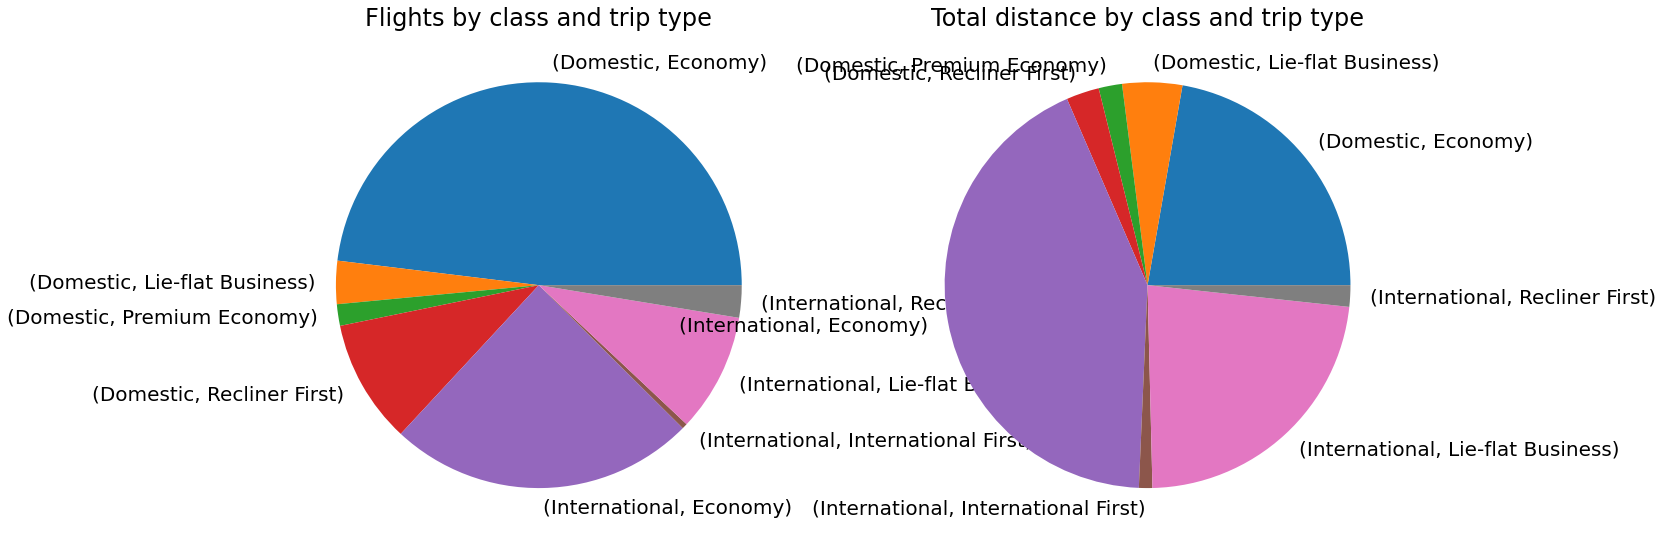

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
clas_dom_int.plot('Class', 'Flights', kind='pie', legend=False, ax=ax[0])
clas_dom_int.plot('Class', 'Distance', kind='pie', legend=False, ax=ax[1])
ax[0].set_title('Flights by class and trip type')
ax[1].set_title('Total distance by class and trip type')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig('figures/class_and_type.jpg', bbox_inches='tight')

# DEP, ARR TIMES, DELAYS

In [68]:
# ARRIVAL DEAYS

early_arrivals = df[df['Arr Delay'] < 0].shape[0]
on_time_arrivals = df[(df['Arr Delay'] >= 0) & (df['Arr Delay'] < 15)].shape[0]
late_arrivals = df[(df['Arr Delay'] >= 15) & (df['Arr Delay'] < 60)].shape[0]
really_late_arrivals = df[df['Arr Delay'] >= 60].shape[0]

print('Early arrivals:', early_arrivals, str(round(100*early_arrivals/NUM_FLIGHTS))+'%')
print('On time arrivals (within 15 min):', on_time_arrivals, str(round(100*on_time_arrivals/NUM_FLIGHTS))+'%')
print('Late arrivals:', late_arrivals, str(round(100*late_arrivals/NUM_FLIGHTS))+'%')
print('Really late arrivals (1+hour):', really_late_arrivals, str(round(100*really_late_arrivals/NUM_FLIGHTS))+'%')

df.sort_values('Arr Delay', ascending=False).head(50)[important_cols]

Early arrivals: 161 69%
On time arrivals (within 15 min): 31 13%
Late arrivals: 27 12%
Really late arrivals (1+hour): 7 3%


,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Distance,Dep Delay,Arr Delay,Class,Aircraft,Registration
148,2020-08-28,2020-08-28 23:45:00,2020-08-29 06:51:00,04:28:00,United,UA1104,ANC,DEN,2405.320211,270.0,232.0,Economy,B738,N73275
210,2022-08-04,2022-08-04 20:30:00,2022-08-04 23:41:00,04:56:00,United,UA1257,EWR,SFO,2565.270251,243.0,168.0,Premium Economy,B77W,N2644U
35,2017-03-11,2017-03-11 12:00:00,2017-03-12 15:00:00,12:44:00,United,UA89,EWR,PEK,6830.922824,224.0,148.0,Economy,B772,N76010
175,2021-06-04,2021-06-04 15:10:00,2021-06-04 16:21:00,00:47:00,United,UA3433,EWR,BOS,200.540719,170.0,146.0,Economy,E170,N646RW
137,2020-02-19,2020-02-19 06:46:00,2020-02-19 08:25:00,01:16:00,JetBlue,B6159,BOS,PHL,280.020205,109.0,86.0,Economy,A321,N903JB
125,2019-12-18,2019-12-18 20:30:00,2019-12-19 18:00:00,13:34:00,United,UA1122,EWR,CPT,7816.760114,134.0,77.0,Lie-flat Business,B789,N27957
76,2018-04-02,2018-04-02 15:30:00,2018-04-02 17:35:00,05:04:00,Wow,WW125,KEF,BOS,2412.851885,121.0,60.0,Economy,A321,TFMOM
45,2017-06-09,2017-06-09 08:40:00,2017-06-09 09:45:00,01:06:00,China Southern,CZ6613,URC,KJI,298.921899,58.0,59.0,Economy,B737,B5239
222,2022-12-11,2022-12-11 09:20:00,2022-12-12 17:30:00,07:42:00,Air New Zealand,NZ9,HNL,AKL,4388.769219,146.0,58.0,Economy,B789,ZK-NZF
51,2017-07-19,2017-07-19 22:10:00,2017-07-20 00:30:00,01:37:00,Hainan,HU7610,PVG,PEK,682.277699,100.0,57.0,Economy,B789,B7880


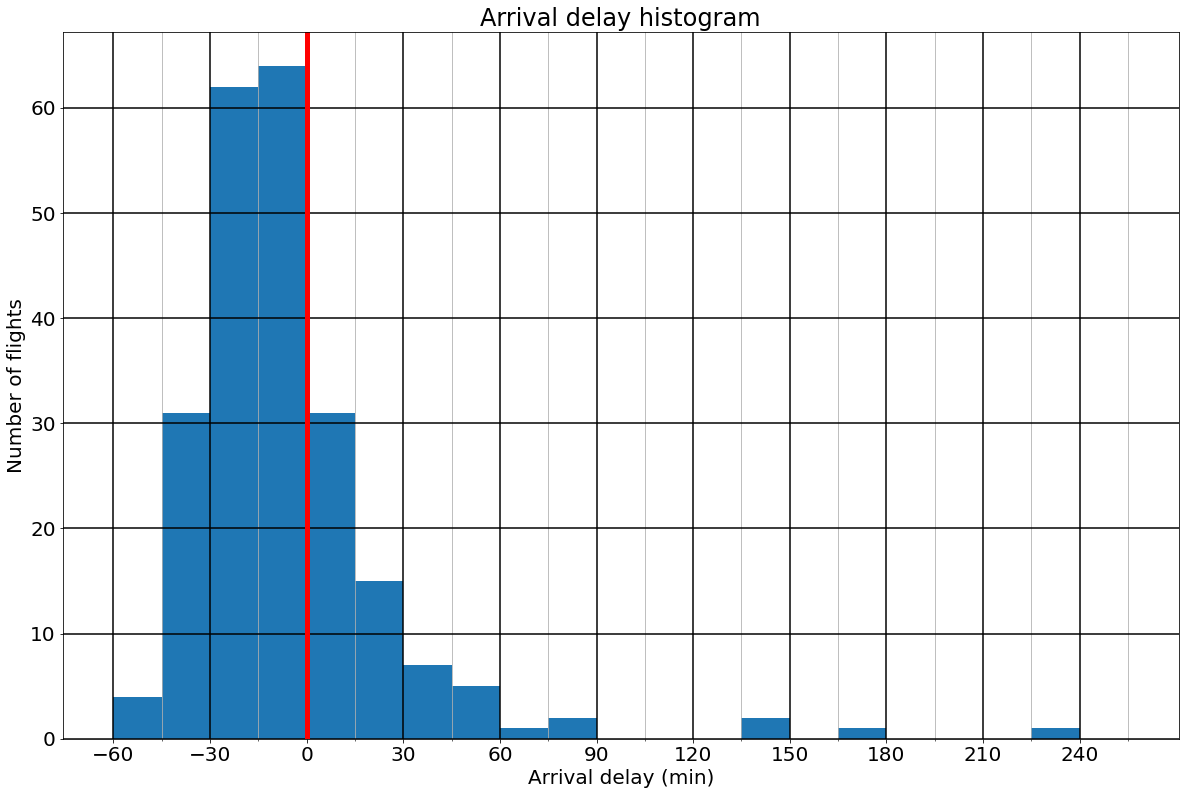

In [69]:
bins = list(range(-60, math.ceil(df['Arr Delay'].max()/30)*30+30, 15))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(df['Arr Delay'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Arrival delay (min)')
ax.set_ylabel('Number of flights')
ax.set_title('Arrival delay histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig('figures/arrival_delay.jpg', bbox_inches='tight')


In [70]:
# DEPARTURE DELAYS

early_departures = df[df['Dep Delay'] < 0].shape[0]
on_time_departures = df[(df['Dep Delay'] >= 0) & (df['Dep Delay'] < 15)].shape[0]
late_departures = df[(df['Dep Delay'] >= 15) & (df['Dep Delay'] < 60)].shape[0]
really_late_departures = df[df['Dep Delay'] >= 60].shape[0]


print('Early departures:', early_departures, str(round(100*early_departures/NUM_FLIGHTS))+'%')
print('On time departures (within 15 min):', on_time_departures, str(round(100*on_time_departures/NUM_FLIGHTS))+'%')
print('Late departures:', late_departures, str(round(100*late_departures/NUM_FLIGHTS))+'%')
print('Really late departures (1+hour):', really_late_departures, str(round(100*really_late_departures/NUM_FLIGHTS))+'%')

df.sort_values('Dep Delay', ascending=False).head(10)[important_cols]

Early departures: 2 1%
On time departures (within 15 min): 82 35%
Late departures: 129 55%
Really late departures (1+hour): 13 6%


,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Distance,Dep Delay,Arr Delay,Class,Aircraft,Registration
148,2020-08-28,2020-08-28 23:45:00,2020-08-29 06:51:00,04:28:00,United,UA1104,ANC,DEN,2405.320211,270.0,232.0,Economy,B738,N73275
210,2022-08-04,2022-08-04 20:30:00,2022-08-04 23:41:00,04:56:00,United,UA1257,EWR,SFO,2565.270251,243.0,168.0,Premium Economy,B77W,N2644U
35,2017-03-11,2017-03-11 12:00:00,2017-03-12 15:00:00,12:44:00,United,UA89,EWR,PEK,6830.922824,224.0,148.0,Economy,B772,N76010
175,2021-06-04,2021-06-04 15:10:00,2021-06-04 16:21:00,00:47:00,United,UA3433,EWR,BOS,200.540719,170.0,146.0,Economy,E170,N646RW
222,2022-12-11,2022-12-11 09:20:00,2022-12-12 17:30:00,07:42:00,Air New Zealand,NZ9,HNL,AKL,4388.769219,146.0,58.0,Economy,B789,ZK-NZF
125,2019-12-18,2019-12-18 20:30:00,2019-12-19 18:00:00,13:34:00,United,UA1122,EWR,CPT,7816.760114,134.0,77.0,Lie-flat Business,B789,N27957
76,2018-04-02,2018-04-02 15:30:00,2018-04-02 17:35:00,05:04:00,Wow,WW125,KEF,BOS,2412.851885,121.0,60.0,Economy,A321,TFMOM
137,2020-02-19,2020-02-19 06:46:00,2020-02-19 08:25:00,01:16:00,JetBlue,B6159,BOS,PHL,280.020205,109.0,86.0,Economy,A321,N903JB
51,2017-07-19,2017-07-19 22:10:00,2017-07-20 00:30:00,01:37:00,Hainan,HU7610,PVG,PEK,682.277699,100.0,57.0,Economy,B789,B7880
97,2019-01-06,2019-01-06 23:55:00,2019-01-07 05:05:00,13:50:00,Air Canada,AC57,DXB,YYZ,6899.002047,74.0,54.0,Lie-flat Business,B77W,CFRAM


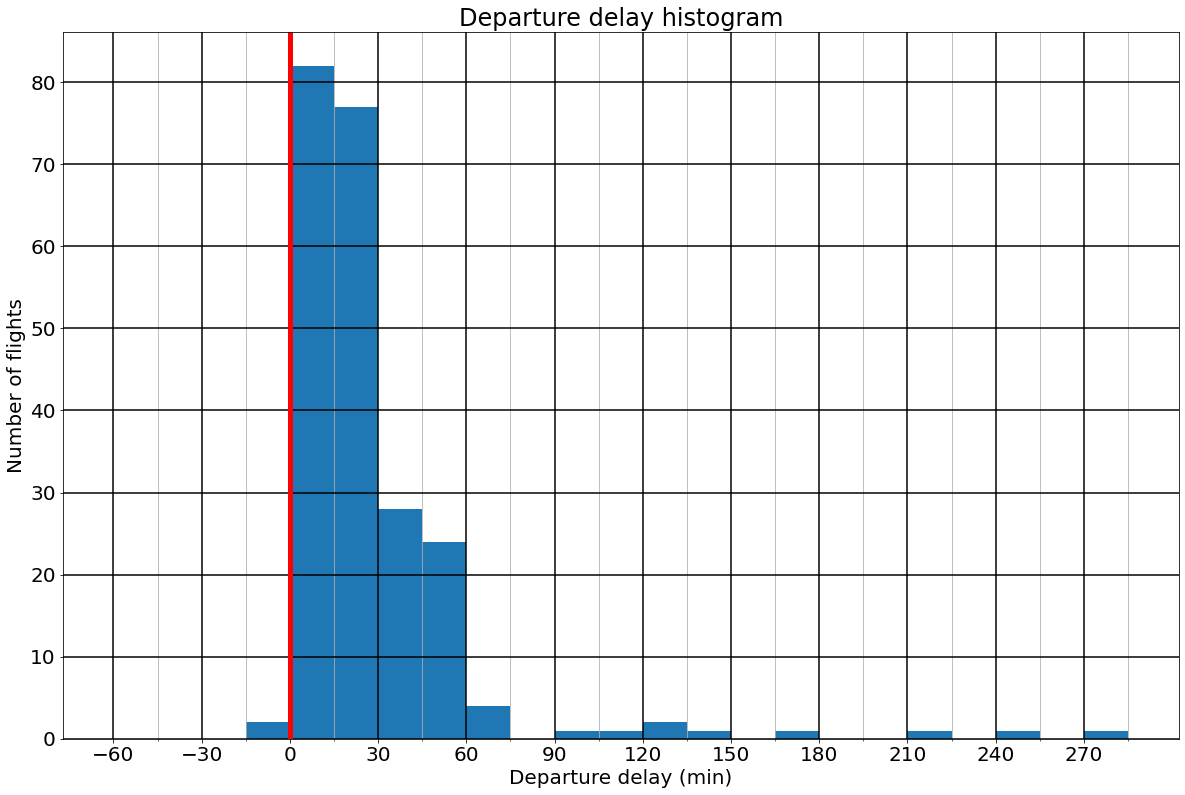

In [71]:
bins = list(range(-60, math.ceil(df['Dep Delay'].max()/30)*30+30, 15))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(df['Dep Delay'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Departure delay (min)')
ax.set_ylabel('Number of flights')
ax.set_title('Departure delay histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig('figures/departure_delay.jpg', bbox_inches='tight')


# DEPARTURE/ARRIVAL TIMES

Morning flights (5a-12p): 91, 39%
Afternoon flights (12p-6p): 75, 32%
Evening flights (6p-11p): 53, 23%
Late nights flights (11p-5a): 12, 5%


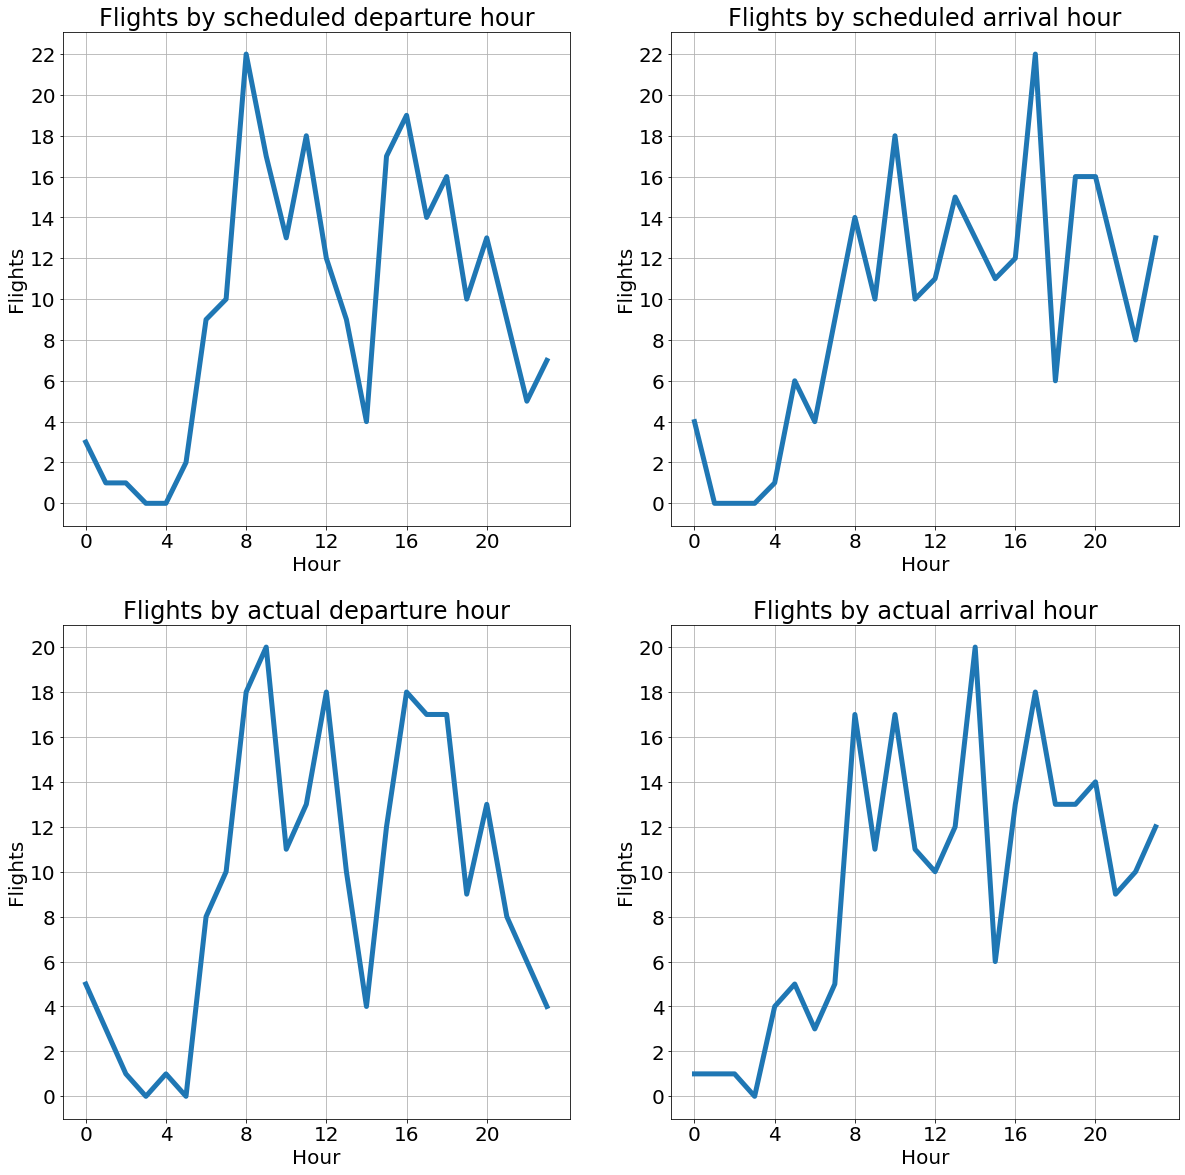

In [72]:
morning_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 5) & (df['Scheduled Dep Time (Local)'].dt.hour <= 11)].shape[0]
afternoon_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 12) & (df['Scheduled Dep Time (Local)'].dt.hour <= 17)].shape[0]
evening_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 18) & (df['Scheduled Dep Time (Local)'].dt.hour <= 22)].shape[0]
late_night_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 23) | (df['Scheduled Dep Time (Local)'].dt.hour <= 4)].shape[0]

print('Morning flights (5a-12p): ' + str(morning_flights) + ', ' + str(int(round(100*morning_flights/NUM_FLIGHTS))) + '%')
print('Afternoon flights (12p-6p): ' + str(afternoon_flights) + ', ' + str(int(round(100*afternoon_flights/NUM_FLIGHTS))) + '%')
print('Evening flights (6p-11p): ' + str(evening_flights) + ', ' + str(int(round(100*evening_flights/NUM_FLIGHTS))) + '%')
print('Late nights flights (11p-5a): ' + str(late_night_flights) + ', ' + str(int(round(100*late_night_flights/NUM_FLIGHTS))) + '%')

df['Scheduled dep hour'] = df['Scheduled Dep Time (Local)'].dt.hour
df['Scheduled arr hour'] = df['Scheduled Arr Time (Local)'].dt.hour
df['Actual dep hour'] = df['Actual Dep Time (Local)'].dt.hour
df['Actual arr hour'] = df['Actual Arr Time (Local)'].dt.hour

scheduled_dep_hour = df.groupby('Scheduled dep hour') .agg({'Date': 'count'}).reset_index().rename(columns={'Scheduled dep hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(scheduled_dep_hour['Hour']):
    scheduled_dep_hour = scheduled_dep_hour.append(pd.DataFrame({'Hour': h, 'Count': 0}, index=[0]))
scheduled_dep_hour = scheduled_dep_hour.sort_values(by='Hour')

scheduled_arr_hour = df.groupby('Scheduled arr hour').agg({'Date': 'count'}).reset_index().rename(columns={'Scheduled arr hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(scheduled_arr_hour['Hour']):
    scheduled_arr_hour = scheduled_arr_hour.append(pd.DataFrame({'Hour': h, 'Count': 0}, index=[0]))
scheduled_arr_hour = scheduled_arr_hour.sort_values(by='Hour')

actual_dep_hour = df.groupby('Actual dep hour').agg({'Date': 'count'}).reset_index().rename(columns={'Actual dep hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(actual_dep_hour['Hour']):
    actual_dep_hour = actual_dep_hour.append(pd.DataFrame({'Hour': h, 'Count': 0}, index=[0]))
actual_dep_hour = actual_dep_hour.sort_values(by='Hour')

actual_arr_hour = df.groupby('Actual arr hour').agg({'Date': 'count'}).reset_index().rename(columns={'Actual arr hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(actual_arr_hour['Hour']):
    actual_arr_hour = actual_arr_hour.append(pd.DataFrame({'Hour': h, 'Count': 0}, index=[0]))
actual_arr_hour = actual_arr_hour.sort_values(by='Hour')

fig, ax = plt.subplots(2, 2, figsize=(20,20))
ax[0, 0].plot(scheduled_dep_hour['Hour'], scheduled_dep_hour['Count'], linewidth=5)
ax[0, 0].grid(True)
ax[0, 0].set_xticks(range(0,24,4))
ax[0, 0].set_xlabel('Hour')
ax[0, 0].set_yticks(np.arange(min(scheduled_dep_hour['Count']), max(scheduled_dep_hour['Count'])+1, 2.0))
ax[0, 0].set_ylabel('Flights')
ax[0, 0].set_title('Flights by scheduled departure hour')

ax[1, 0].plot(actual_dep_hour['Hour'], actual_dep_hour['Count'], linewidth=5)
ax[1, 0].grid(True)
ax[1, 0].set_xticks(range(0,24,4))
ax[1, 0].set_xlabel('Hour')
ax[1, 0].set_yticks(np.arange(min(actual_dep_hour['Count']), max(actual_dep_hour['Count'])+1, 2.0))
ax[1, 0].set_ylabel('Flights')
ax[1, 0].set_title('Flights by actual departure hour')

ax[0, 1].plot(scheduled_arr_hour['Hour'], scheduled_arr_hour['Count'], linewidth=5)
ax[0, 1].grid(True)
ax[0, 1].set_xticks(range(0,24,4))
ax[0, 1].set_xlabel('Hour')
ax[0, 1].set_yticks(np.arange(min(scheduled_arr_hour['Count']), max(scheduled_arr_hour['Count'])+1, 2.0))
ax[0, 1].set_ylabel('Flights')
ax[0, 1].set_title('Flights by scheduled arrival hour')

ax[1, 1].plot(actual_arr_hour['Hour'], actual_arr_hour['Count'], linewidth=5)
ax[1, 1].grid(True)
ax[1, 1].set_xticks(range(0,24,4))
ax[1, 1].set_xlabel('Hour')
ax[1, 1].set_yticks(np.arange(min(actual_arr_hour['Count']), max(actual_arr_hour['Count'])+1, 2.0))
ax[1, 1].set_ylabel('Flights')
ax[1, 1].set_title('Flights by actual arrival hour')
plt.savefig('figures/by_hour.jpg', bbox_inches='tight')



# ROUTES

In [73]:
import pyproj
from geojson import LineString, Feature, FeatureCollection, dump
import geopy.distance


def get_hist(x):
    dct = {a: x.tolist().count(a) for a in x.tolist()}
    return ';'.join([str(list(dct.keys())[i]) + ',' + str(list(dct.values())[i]) for i in range(len(dct))])


def augment_routes(df):
    route_grouped = df.groupby('Sorted Route')
    df[['Class', 'Airline', 'Flight']] = df[['Class', 'Airline', 'Flight']].fillna('Unknown')
    df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
    df['route_class_hist'] = route_grouped['Class'].transform(get_hist)#(lambda x: str(x.tolist().count('Economy')) + ',' + str(x.tolist().count('Business')))
    df['route_airline_hist'] = route_grouped['Airline'].transform(get_hist)
    df['route_flight_string'] = route_grouped['Flight'].transform(lambda x: ';'.join(x))
    df['route_origin_hist'] = route_grouped['Dep Airport'].transform(get_hist)
    grouped = df.groupby('Sorted Route').first()[['Distance', 'Duration', 'Domestic/International',
                                        'route_date_string', 'route_class_hist', 'route_airline_hist', 'route_flight_string', 'route_origin_hist'
                                       ]]
    grouped['count'] = grouped['route_date_string'].apply(lambda x: len(x.split(';')))

    grouped = grouped.reset_index()
    grouped['Dep IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[0])
    grouped['Arr IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[1])
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Dep IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'City': 'Dep City', 'Country': 'Dep Country', 'Lat': 'Dep Lat', 'Long': 'Dep Long'})
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Arr IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'City': 'Arr City', 'Country': 'Arr Country', 'Lat': 'Arr Lat', 'Long': 'Arr Long'})

    return grouped




def get_path(startlong, startlat, endlong, endlat):
    # calculate distance between points
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

    # calculate line string along path with segments <= 1 km
    lonlats = g.npts(startlong, startlat, endlong, endlat,
                     1 + int(dist / 5000))
    
    # npts doesn't include start/end points, so prepend/append them
    lonlats.insert(0, (startlong, startlat))
    lonlats.append((endlong, endlat))
    offset = 0
    for i in range(len(lonlats)-1):
        if lonlats[i][0] > 0 and lonlats[i+1][0] < 0 and lonlats[i+1][0] < -170:
            offset = 360
        elif lonlats[i][0] < 0 and lonlats[i+1][0] > 0 and lonlats[i+1][0] > 170:
            offset = -360
        lonlats[i+1] = (lonlats[i+1][0] + offset , lonlats[i+1][1])
#     print(len(lonlats))
    return LineString(lonlats)


def make_route_geojson(df, path):
    
    grouped = augment_routes(df)
    
    features = []
    for i, row in grouped.iterrows():
    #     lats = row['Sorted Lat'].split(';')
    #     longs = row['Sorted Long'].split(';')
        properties = properties = {'start_iata': row['Dep IATA'], 
                              'start_name': row['Dep Name'], 
                              'start_city_country': row['Dep City'] + ', ' + row['Dep Country'], 
                              'end_iata': row['Arr IATA'], 
                              'end_name': row['Arr Name'], 
                              'end_city_country': row['Arr City'] + ', ' + row['Arr Country'],  
                              'dist': row['Distance'], 
                              'dur': row['Duration'],
                              'domint': row['Domestic/International'],
                              'count': row['count'],
                              'earliest_date': row['route_date_string'].split(';')[0].split(' ')[0],
                              'latest_date': row['route_date_string'].split(';')[-1].split(' ')[0],
                              'date_string': row['route_date_string'],
                              'class_hist': row['route_class_hist'],
                              'airline_hist': row['route_airline_hist'],
                              'flight_string': row['route_flight_string'],
                              'origin_hist': row['route_origin_hist']
                             }
        features.append(Feature(geometry=get_path(row['Dep Long'], row['Dep Lat'], 
                                                  row['Arr Long'], row['Arr Lat']),
                                properties = properties))
    fc = FeatureCollection(features)

    with open(path, 'w') as f:
        dump(fc, f)



# AIRPORTS AUGMENTED

In [74]:
from geojson import Point, Feature, FeatureCollection, dump

def augment_airports(df):
    df['Year'] = df['Date'].dt.year

    dep_grouped = df.groupby('Dep Airport')
    df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
    df['dep_count'] = dep_grouped['Date'].transform(lambda v: v.shape[0])
    df['dep_first'] = dep_grouped['Date'].transform(lambda v: min(v))
    df['dep_last'] = dep_grouped['Date'].transform(lambda v: max(v))
    df['dep_airline_hist'] = dep_grouped['Airline'].transform(get_hist)
    df['dep_intdom_hist'] = dep_grouped['Domestic/International'].transform(get_hist)
    df['dep_year_hist'] = dep_grouped['Year'].transform(get_hist)

    arr_grouped = df.groupby('Arr Airport')
    df['arr_dest_hist'] = arr_grouped['Dep Airport'].transform(get_hist)
    df['arr_count'] = arr_grouped['Date'].transform(lambda v: v.shape[0])
    df['arr_first'] = arr_grouped['Date'].transform(lambda v: min(v))
    df['arr_last'] = arr_grouped['Date'].transform(lambda v: max(v))
    df['arr_conn_count'] = arr_grouped['Arr Connect'].transform(lambda v: int(v.sum())).astype('int')
    df['arr_airline_hist'] = arr_grouped['Airline'].transform(get_hist)
    df['arr_intdom_hist'] = arr_grouped['Domestic/International'].transform(get_hist)
    df['arr_year_hist'] = arr_grouped['Year'].transform(get_hist)

    df['arr_conn_year_hist'] = df[df['Arr Connect'] == 1].groupby('Arr Airport')['Year'].transform(get_hist)

    df = df.drop(columns='arr_conn_year_hist').merge(df[['Arr Airport', 'arr_conn_year_hist']].dropna().drop_duplicates(), on='Arr Airport', how='left')

    deps = df.groupby('Dep Airport').first()[['Dep Name', 'Dep City', 'Dep Country', 'Dep Lat', 'Dep Long',
                                       'dep_dest_hist', 'dep_count', 'dep_first', 'dep_last', 'dep_airline_hist', 'dep_intdom_hist', 'dep_year_hist'
                                      ]].reset_index()
    arrcons = df.groupby('Arr Airport').first()[['Arr Name', 'Arr City', 'Arr Country', 'Arr Lat', 'Arr Long',
                                                 'arr_dest_hist', 'arr_count', 'arr_first', 'arr_last', 'arr_airline_hist', 'arr_intdom_hist', 'arr_year_hist',
                                       'arr_conn_count', 'arr_conn_year_hist'
                                      ]].reset_index()
    airports_aug = deps.merge(arrcons, left_on='Dep Airport', right_on='Arr Airport', how='outer')
    
    def merge_names(row):
        for col in ['Airport', 'Name', 'City', 'Country']:
            row[col] = row['Dep '+ col] if type(row['Dep '+ col]) == str else row['Arr '+ col]
        for col in ['Lat', 'Long']:
            row[col] = row['Dep '+ col] if not np.isnan(row['Dep '+ col]) else row['Arr '+ col]
        return row


    airports_aug = airports_aug.apply(merge_names, axis=1)
    airports_aug = airports_aug.rename(columns={'Airport': 'IATA'})

    airports_aug = airports_aug[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long',
                                 'dep_count', 'arr_count', 'arr_conn_count',
                                 'dep_dest_hist', 'arr_dest_hist',
                                 'dep_first', 'arr_first', 'dep_last', 'arr_last',
                                 'dep_airline_hist', 'arr_airline_hist',
                                 'dep_intdom_hist', 'arr_intdom_hist',
                                 'dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist'
                                ]]
    airports_aug['dep_count'] = airports_aug['dep_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)
    airports_aug['arr_count'] = airports_aug['arr_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)

    def subtract_hist(row):
        dep_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['dep_year_hist'].split(';')} if row['dep_year_hist'] != '' else {}
        arr_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_year_hist'].split(';')} if row['arr_year_hist'] != '' else {}
        conn_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_conn_year_hist'].split(';')} if row['arr_conn_year_hist'] != '' else {}

        for year in conn_hist:
            if year in dep_hist:
                dep_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in dep')
            if year in arr_hist:
                arr_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in arr')

        row['dep_year_hist'] = ';'.join([str(x) + ',' + str(dep_hist[x]) for x in dep_hist if dep_hist[x] > 0])
        row['arr_year_hist'] = ';'.join([str(x) + ',' + str(arr_hist[x]) for x in arr_hist if arr_hist[x] > 0])
        full_year_hist = {}
        for key in dep_hist:
            full_year_hist[key] = full_year_hist[key] + dep_hist[key] if key in full_year_hist else dep_hist[key]
        for key in arr_hist:
            full_year_hist[key] = full_year_hist[key] + arr_hist[key] if key in full_year_hist else arr_hist[key]
        for key in conn_hist:
            full_year_hist[key] = full_year_hist[key] + conn_hist[key] if key in full_year_hist else conn_hist[key]
        row['full_year_hist'] = ';'.join([str(x) + ',' + str(full_year_hist[x]) for x in full_year_hist if full_year_hist[x] > 0])
        return row

    airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']] = airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']].fillna('')
    airports_aug = airports_aug.apply(subtract_hist, axis=1)
    airports_aug['total'] = airports_aug['dep_count'].fillna(0) + airports_aug['arr_count'].fillna(0) + airports_aug['arr_conn_count'].fillna(0)
    airports_aug['first'] = airports_aug.apply(lambda row: min(row['dep_first'], row['arr_first']), axis=1)
    airports_aug['last'] = airports_aug.apply(lambda row: min(row['dep_last'], row['arr_last']), axis=1)
    year_airports_aug.append(airports_aug)
    return airports_aug

def make_airport_geojson(df, path):
    airports_aug = augment_airports(df)
    for col in ['dep_first', 'arr_first', 'dep_last', 'arr_last', 'first', 'last']:
        airports_aug[col] = airports_aug[col].dt.strftime('%Y-%m-%d')
    airports_aug = airports_aug.fillna('')
    features = []
    for i, row in airports_aug.iterrows():
#         print(row.drop(['Lat', 'Long']).to_dict())
        features.append(Feature(geometry=Point((row['Long'], row['Lat'])), properties=row.drop(['Lat', 'Long']).to_dict()))
    fc = FeatureCollection(features)
    with open(path, 'w') as f:
        dump(fc, f)


In [ ]:
#### MAKE ROUTES
year_airports_aug = [] # first one is all

make_route_geojson(df, ROOT_DIR + 'routes_all.geojson')
make_airport_geojson(df, ROOT_DIR + 'airports_all.geojson')

all_years = df['Date'].dt.year.unique().tolist()
first_month = min(df[df['Date'].dt.year == all_years[0]]['Date'].dt.month)
last_month = max(df[df['Date'].dt.year == all_years[-1]]['Date'].dt.month)

with open(ROOT_DIR + "month_range.txt", "w") as text_file:
    text_file.write(','.join(str(x) for x in all_years) + '\n' + str(first_month) + ',' + str(last_month))

for year in all_years:
    make_route_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'routes_' + str(year) + '.geojson')
    make_airport_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'airports_' + str(year) + '.geojson')

print('years done')

for year in all_years:
    print(year)
    for month in range(1, 13):
        if year == all_years[0] and month < first_month:
            continue
        if year == all_years[-1] and month > last_month:
            continue
        print('  ', month)
        simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
        make_route_geojson(simp_df, ROOT_DIR + 'routes_cum_' + str(year) + '_' + str(month) + '.geojson')
        make_airport_geojson(simp_df, ROOT_DIR + 'airports_cum_' + str(year) + '_' + str(month) + '.geojson')
    


/Users/alexanderguo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-73-373e90645454>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
<ipython-input-73-373e90645454>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

<ipython-input-74-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-74-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-74-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<ipython-input-74-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-74-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-74-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<ipython-input-74-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-74-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-74-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<ipython-input-74-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-74-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-74-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<ipython-input-74-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-74-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-74-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<ipython-input-74-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-74-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-74-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<ipython-input-74-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-74-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-74-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

years done
2015
   3
   4
   5


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6
   7
   8


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9
   10
   11


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12
2016
   1


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2
   3


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4
   5


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9
   10


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11
   12


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2017
   1


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2018
   1


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-75-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


# PRINTING

In [ ]:
def get_stats(df, airports_aug, year=None, ab=False):
    print(year)
    TOTAL_DIST = df['Distance'].sum()
    TOTAL_TIME = df['Duration'].sum()
    NUM_FLIGHTS = df['Date'].count()
    NUM_AIRLINES = df['Airline'].nunique()
    NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
    NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))

    dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
    dep_countries.columns = ['Country', 'Airport', 'Departures']
    arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
    arr_countries.columns = ['Country', 'Airport', 'Arrivals']
    countries = pd.merge(dep_countries, arr_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first'})
    countries['Total Dep/Arr'] = countries['Departures'] + countries['Arrivals']

    routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum, 'Duration': sum}).sort_values(by='Date', ascending=False)
    routes_sorted.columns = ['Count', 'Total Distance', 'Duration']

    airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum, 'Duration': sum}).sort_values(by='Date', ascending=False)
    airlines.columns = ['Count', 'Total Distance', 'Duration']

    dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Date': 'count', 'Duration': sum})
    dist_year.columns = ['Distance', 'Flights', 'Duration']

    dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count', 'Duration': sum})
    dom_int.columns = ['Distance', 'Flights', 'Duration']

    clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count', 'Duration': sum})
    clas.columns = ['Distance', 'Flights', 'Duration']
   
    early_arrivals = df[df['Arr Delay'] < 0].shape[0]
    on_time_arrivals = df[(df['Arr Delay'] >= 0) & (df['Arr Delay'] < 15)].shape[0]
    late_arrivals = df[(df['Arr Delay'] >= 15) & (df['Arr Delay'] < 60)].shape[0]
    really_late_arrivals = df[df['Arr Delay'] >= 60].shape[0]

    morning_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 5) & (df['Scheduled Dep Time (Local)'].dt.hour <= 11)].shape[0]
    afternoon_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 12) & (df['Scheduled Dep Time (Local)'].dt.hour <= 17)].shape[0]
    evening_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 18) & (df['Scheduled Dep Time (Local)'].dt.hour <= 22)].shape[0]
    late_night_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 23) | (df['Scheduled Dep Time (Local)'].dt.hour <= 4)].shape[0]

    def get_time(minutes):
        return [int(minutes//60), int(minutes % 60)]

    def get_time_str(minutes):
        if get_time(minutes)[0] == 0:
            return str(get_time(minutes)[1]) + 'min'
        else:
            return str(get_time(minutes)[0]) + 'h ' + str(get_time(minutes)[1]) + 'm'

        
    big_str = ''
    if ab:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(first_month) + '/' + str(all_years[0]) + '-' + str(last_month) + '/' + str(all_years[-1]) + ')</span></h2>'
    else:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(year) + ')</span></h2>'
        
    big_str += '<p>Total Distance Flown: <span class=\'bold\'>' + '{:,}'.format(TOTAL_DIST).split('.')[0] + '</span>mi' + '\n'
    big_str += '<br>Total Time in Air: <span class=\'bold\'>' + str(timedelta(minutes=int(TOTAL_TIME))) + '</span>' + '\n'
    big_str += '<br>Total Flights: <span class=\'bold\'>' + str(NUM_FLIGHTS) + '</span>' + '\n'
    big_str += '<br>Number of Airlines: <span class=\'bold\'>' + str(NUM_AIRLINES) + '</span>'
    big_str += ', Countries: <span class=\'bold\'>' + str(NUM_COUNTRIES) + '</span>'
    big_str += ', Airports: <span class=\'bold\'>' + str(NUM_AIRPORTS) + '</span>' + '\n'
    big_str += '<p>Longest interval between flights: <span class=\'bold\'>' + str(LONGEST_INTERVAL) + '</span> (' + str(LONGEST_INTERVAL_0) + ' to ' + str(LONGEST_INTERVAL_1) + ')\n'
    big_str += '<br>Month with most flying: <span class=\'bold\'>' 
    big_str += str(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Y-M']) + '</span> (' 
    big_str += str(int(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Flights'])) + ' flights, '
    big_str += get_time_str(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Duration']) + ') or <span class=\'bold\'>'
    big_str += str(a.sort_values('Duration', ascending=False).reset_index().loc[0, 'Y-M']) + '</span> (' 
    big_str += str(int(a.sort_values('Duration', ascending=False).reset_index().loc[0, 'Flights'])) + ' flights, '
    big_str += get_time_str(a.sort_values('Duration', ascending=False).reset_index().loc[0, 'Duration']) + ')\n'


    by_dist = df[df['Duration'] != 0.0].sort_values(by='Duration')
    print(by_dist)
    big_str += ('<p>Shortest flight: <span class=\'bold\'>' + by_dist.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + '{:,}'.format(by_dist.iloc[0]['Distance']).split('.')[0] + 'mi, ' + get_time_str(by_dist.iloc[0]['Duration']) + ')' + '\n')


    by_dist2 = df.sort_values(by='Duration', ascending=False)
    big_str += ('<br>Longest flight: <span class=\'bold\'>' + by_dist2.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist2.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + '{:,}'.format(by_dist2.iloc[0]['Distance']).split('.')[0] + 'mi, ' + get_time_str(by_dist2.iloc[0]['Duration']) + ')</p>' + '\n')

    countries_list = countries.reset_index().groupby('Country').count().reset_index()[['Country', 'Airport']].sort_values(by='Airport', ascending=False).values.tolist()
    country_airport = '<p>Airport distribution (top countries): '
    for country, airports in countries_list[:5]:
        country_airport += '<span class=\'bold\'>' + country + '</span>: ' + str(airports) + ', '
    country_airport = country_airport[:-2]
    big_str += country_airport + '\n'

    # visited_airports
    visited_list = airports_aug.sort_values(by='total', ascending=False)[['IATA', 'total']].values.tolist()
    visited_airports = '<br>Airports by total visits: '
    for airport, total in visited_list[:5]:
        visited_airports += '<span class=\'bold\'>' + airport + '</span>: ' + str(int(total)) + ', '
    visited_airports = visited_airports[:-2]
    big_str += visited_airports + '\n'

    routes_list = routes_sorted.reset_index()[['Sorted Route', 'Count']].values.tolist()
    top_routes = '<br>Top routes: '
    for route, count in routes_list[:5]:
        top_routes += '<span class=\'bold\'>' + route.split(' ')[0] + '</span> to <span class=\'bold\'>' + route.split(' ')[1] + '</span>: ' + str(int(count)) + ', '
    top_routes = top_routes[:-2]
    big_str += top_routes + '\n'

    airlines_list = airlines.reset_index()[['Airline', 'Count']].values.tolist()
    top_airlines = '<br>Top airlines: '
    for airline, count in airlines_list[:5]:
        top_airlines += '<span class=\'bold\'>' + airline + '</span>: ' + str(int(count)) + ', '
    top_airlines = top_airlines[:-2]
    big_str += top_airlines + '\n'

    big_str += '<p>Early arrivals: <span class=\'bold\'>' + str(early_arrivals) + '</span> (' + str(round(100*early_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>On-time arrivals (within 15min): <span class=\'bold\'>' + str(on_time_arrivals) + '</span> (' + str(round(100*on_time_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Late arrivals (up to 1hr delay): <span class=\'bold\'>' + str(late_arrivals) + '</span> (' + str(round(100*late_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Really late arrivals (>1hr delay): <span class=\'bold\'>' + str(really_late_arrivals) + '</span> (' + str(round(100*really_late_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '</p>\n'
    
    big_str += '<p>Morning flights (5am-12p): <span class=\'bold\'>' + str(morning_flights) + '</span> (' + str(round(100*morning_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Afternoon flights (12p-6p): <span class=\'bold\'>' + str(afternoon_flights) + '</span> (' + str(round(100*afternoon_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Evening flights (6p-11p): <span class=\'bold\'>' + str(evening_flights) + '</span> (' + str(round(100*evening_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Late night flights (11p-5a): <span class=\'bold\'>' + str(late_night_flights) + '</span> (' + str(round(100*late_night_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '</p>\n'
    
    dom_int_list = dom_int.reset_index()[['Domestic/International', 'Distance', 'Flights']].values.tolist()
    domint = '<p>'
    for di, dist, count in dom_int_list:
        domint += '<span class=\'bold\'>' + di + '</span>: ' + '{:,}'.format(dist).split('.')[0] + 'mi, ' + str(int(count)) + ' flights\n<br>'
    domint = domint[:-5] + '</p>'
    big_str += domint + '\n'

    class_list = clas.reset_index()[['Class', 'Distance', 'Flights']].values.tolist()
    class_str = '<p>'
    for c, dist, count in class_list:
        class_str += '<span class=\'bold\'>' + c + '</span>: ' + '{:,}'.format(dist).split('.')[0] + 'mi, ' + str(int(count)) + ' flights\n<br>'
    class_str = class_str[:-5] + '</p>'
    big_str += class_str + '\n'
    
    if ab: # ind years don't need this
        print(dist_year.reset_index())
        years_list = dist_year.reset_index()[['Date', 'Distance', 'Flights', 'Duration']].values.tolist()
        years = '<p>'
        for year, dist, count, dur in years_list:
            years += '<span class=\'bold\'>' + str(int(year)) + '</span>: ' + get_time_str(dur) + ', ' + str(int(count)) + ' flights, ' + '{:,}'.format(dist).split('.')[0] + 'mi \n<br>'
        years = years[:-5] + '</p>'
        big_str += years + '\n'

#     print(big_str)
    return big_str

big_str = get_stats(df, year_airports_aug[0], ab=True)
with open(ROOT_DIR + "all_stats.txt", "w") as text_file:
    text_file.write(big_str)
for i, year in enumerate(all_years):
    big_str = get_stats(df[df['Date'].dt.year == year], year_airports_aug[i+1], year=year)
    with open(ROOT_DIR + str(year) + "_stats.txt", "w") as text_file:
        text_file.write(big_str)